In [1]:
import datetime
import IPython
import IPython.display
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn import linear_model, preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
print("Versión de Tensorflow: ", tf.__version__)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Versión de Tensorflow:  2.9.1


# Lectura de datos

In [2]:
# Read consumo excel file.
consumo = pd.read_excel("..\Data\Consumo\Consumo_2017_2021.xlsx")

In [3]:
# Print the 'consumo' shape.
print('\n Shape of the data:')
print(consumo.shape)
consumo.head()


 Shape of the data:
(783000, 11)


,Matricula,NombreSuscriptor,Direccion,Servicio,Estrato,NumeroContador,LecturaActual,LecturaAnterior,MetrosConsumidos,Mes,Ano
0,40083,PATINO AREVALO OSCAR,K 5A 9 51 PASAJE,Residencial,3,19144264,6028,6018,10,JULIO,2017
1,40083,PATINO AREVALO OSCAR,K 5A 9 51 PASAJE,Residencial,3,19144264,6051,6028,23,AGOSTO,2017
2,40083,PATINO AREVALO OSCAR,K 5A 9 51 PASAJE,Residencial,3,19144264,6068,6051,17,SEPTIEMBRE,2017
3,40083,PATINO AREVALO OSCAR,K 5A 9 51 PASAJE,Residencial,3,19144264,6085,6068,17,OCTUBRE,2017
4,40083,PATINO AREVALO OSCAR,K 5A 9 51 PASAJE,Residencial,3,19144264,6103,6085,18,NOVIEMBRE,2017


In [4]:
# Print information about 'consumo'.
consumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783000 entries, 0 to 782999
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Matricula         783000 non-null  int64 
 1   NombreSuscriptor  783000 non-null  object
 2   Direccion         783000 non-null  object
 3   Servicio          783000 non-null  object
 4   Estrato           783000 non-null  int64 
 5   NumeroContador    782958 non-null  object
 6   LecturaActual     783000 non-null  int64 
 7   LecturaAnterior   783000 non-null  int64 
 8   MetrosConsumidos  783000 non-null  int64 
 9   Mes               783000 non-null  object
 10  Ano               783000 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 65.7+ MB


In [5]:
# Delete some columns from 'consumo'
consumo.drop(['Matricula',"NombreSuscriptor","Direccion","NumeroContador",'Servicio','Estrato'],
             axis=1,inplace=True) #inplace=True, para que me modifique la BD
consumo.columns

Index(['LecturaActual', 'LecturaAnterior', 'MetrosConsumidos', 'Mes', 'Ano'], dtype='object')

In [6]:
# Delete rows where 'MetrosConsumidos' is less than zero from 'consumo'
consumo = consumo.drop(consumo.index[consumo['MetrosConsumidos'] < 0])
consumo.shape

(782993, 5)

In [7]:
# Cleaning 'Mes' columnn from 'consumo'
consumo["Mes"] = (consumo["Mes"]
                          # .str.lower()
                          #.str.replace("[^a-záéíóúüñ ]","")
                          # .str.replace(" +"," ")
                          .str.replace('[^\w+]|\d+|\s+|_',' ', regex=True)
                          .str.strip()
                          # .str.title()
                          )
consumo["Mes"].astype("str")
consumo["Mes"].head(12)

0          JULIO
1         AGOSTO
2     SEPTIEMBRE
3        OCTUBRE
4      NOVIEMBRE
5      DICIEMBRE
6          ENERO
7        FEBRERO
8          MARZO
9          ABRIL
10          MAYO
11         JUNIO
Name: Mes, dtype: object

In [8]:
# Change month name to number from 'consumo'
cm_dict = {'ENERO':1,'FEBRERO':2,'MARZO':3,'ABRIL':4,'MAYO':5,'JUNIO':6,
          'JULIO':7,'AGOSTO':8,'SEPTIEMBRE':9,'OCTUBRE':10,'NOVIEMBRE':11,'DICIEMBRE':12}
consumo = consumo.replace({'Mes':cm_dict})
consumo.head()

,LecturaActual,LecturaAnterior,MetrosConsumidos,Mes,Ano
0,6028,6018,10,7,2017
1,6051,6028,23,8,2017
2,6068,6051,17,9,2017
3,6085,6068,17,10,2017
4,6103,6085,18,11,2017


In [9]:
# Create a 'Dia' column full of ones in 'consumo'
consumo["Dia"] = 1
Dia = consumo["Dia"]
consumo.head()

,LecturaActual,LecturaAnterior,MetrosConsumidos,Mes,Ano,Dia
0,6028,6018,10,7,2017,1
1,6051,6028,23,8,2017,1
2,6068,6051,17,9,2017,1
3,6085,6068,17,10,2017,1
4,6103,6085,18,11,2017,1


In [10]:
# Change the name of some columns to create a 'Date' column in 'consumo'
consumo.rename(columns = {'Ano':'year','Mes':'month','Dia':'day'}, inplace=True)
consumo['Date'] = pd.to_datetime(consumo[["year","month","day"]])
consumo.head()

,LecturaActual,LecturaAnterior,MetrosConsumidos,month,year,day,Date
0,6028,6018,10,7,2017,1,2017-07-01
1,6051,6028,23,8,2017,1,2017-08-01
2,6068,6051,17,9,2017,1,2017-09-01
3,6085,6068,17,10,2017,1,2017-10-01
4,6103,6085,18,11,2017,1,2017-11-01


In [11]:
# Delete 'year', 'month' and 'day' columns from 'consumo'
consumo.drop(["year","month","day"], axis=1,inplace=True) #inplace=True, para que me modifique la BD
consumo.head()

,LecturaActual,LecturaAnterior,MetrosConsumidos,Date
0,6028,6018,10,2017-07-01
1,6051,6028,23,2017-08-01
2,6068,6051,17,2017-09-01
3,6085,6068,17,2017-10-01
4,6103,6085,18,2017-11-01


In [12]:
# Creat a dataframe with 'consumo' and its target variables and create 'consumo_mensual'.
consumo['Date'] = pd.to_datetime(consumo.Date,format='%Y-%m-%d')
# consumo.index = consumo['Date']
# df = df.sort_index(ascending=True, axis=0)
consumo = pd.DataFrame(consumo[['Date','MetrosConsumidos','LecturaActual','LecturaAnterior']])

# # Set the 'consumo_mensual' index
# consumo.index = consumo.Date
# consumo.drop('Date', axis=1, inplace=True)
# consumo.head()

In [13]:
consumo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782993 entries, 0 to 782999
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              782993 non-null  datetime64[ns]
 1   MetrosConsumidos  782993 non-null  int64         
 2   LecturaActual     782993 non-null  int64         
 3   LecturaAnterior   782993 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 29.9 MB


In [14]:
# Group 'consumo' by 'Date' and create 'consumo_mensual'
consumo_mensual = consumo.groupby('Date',as_index=False).sum()
consumo_mensual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              54 non-null     datetime64[ns]
 1   MetrosConsumidos  54 non-null     int64         
 2   LecturaActual     54 non-null     int64         
 3   LecturaAnterior   54 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.8 KB


In [15]:
consumo_mensual.head(20)

,Date,MetrosConsumidos,LecturaActual,LecturaAnterior
0,2017-07-01,139987,17692115,17552128
1,2017-08-01,222055,17824508,17602453
2,2017-09-01,149277,17816058,17666781
3,2017-10-01,175709,17898418,17722709
4,2017-11-01,175364,18924638,18749274
5,2017-12-01,182861,19131506,18948645
6,2018-01-01,192229,19153741,18961512
7,2018-02-01,180990,19365712,19550302
8,2018-03-01,160001,19146736,19248233
9,2018-04-01,174781,19134356,19102397


In [16]:
# Read clima excel file.
clima = pd.read_excel("..\Data\Climatologicos_Mensual\Climatologicos_Mensual_2017_2022.xlsx")

In [17]:
# Print the 'clima' shape.
print('\n Shape of the data:')
print(clima.shape)
clima.head()


 Shape of the data:
(61, 24)


,Año,Mes,Ppt (mm),DSL (#),TMáx (ºC),TMín (ºC),TPro (ºC),Máx PB (hPa),Mín PB (hPa),Med PB (hPa),...,DB.1,HR Máx (%),HR Mín (%),HR Med (%),CI,SE,RS Máx (W/m2),RS Med (W/m2),IAM,ZAM
0,2017,1,233.2,17,26.7,12.8,19.3,823.0,809.3,816.8,...,Aire ligero,97.0,36.0,83.7,8.9,Agradable,1273,348.0,95.5,Perhúmedas
1,2017,2,107.8,17,27.8,13.2,20.4,822.7,808.3,816.3,...,Aire ligero,98.0,41.0,77.7,7.8,Agradable,1190,399.4,42.6,Húmeda
2,2017,3,293.6,7,26.4,15.2,19.0,822.5,811.2,817.7,...,Aire ligero,98.0,53.0,87.9,9.3,Agradable,1213,278.4,121.5,Perhúmedas
3,2017,4,357.4,14,28.2,14.8,20.1,821.4,809.0,816.1,...,Aire ligero,98.0,43.0,83.6,8.4,Agradable,1311,343.6,142.5,Perhúmedas
4,2017,5,459.6,9,27.3,15.7,19.7,821.8,807.7,817.5,...,Aire ligero,98.0,56.0,87.2,8.9,Agradable,1264,298.3,185.7,Perhúmedas


In [18]:
# Print information about 'clima'.
clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Año            61 non-null     int64  
 1   Mes            61 non-null     int64  
 2   Ppt (mm)       53 non-null     float64
 3   DSL (#)        61 non-null     int64  
 4   TMáx (ºC)      61 non-null     float64
 5   TMín (ºC)      61 non-null     float64
 6   TPro (ºC)      61 non-null     float64
 7   Máx PB (hPa)   61 non-null     float64
 8   Mín PB (hPa)   61 non-null     float64
 9   Med PB (hPa)   61 non-null     float64
 10  EB             61 non-null     int64  
 11  DB             61 non-null     object 
 12  VVPro          61 non-null     float64
 13  EB.1           61 non-null     int64  
 14  DB.1           61 non-null     object 
 15  HR Máx (%)     49 non-null     float64
 16  HR Mín (%)     49 non-null     float64
 17  HR Med (%)     49 non-null     float64
 18  CI          

In [19]:
# Delete some columns from 'clima'
clima.drop(['DSL (#)','EB','DB','EB.1','DB.1',"CI","SE",'ZAM'],
           axis=1,inplace=True) #inplace=True, para que me modifique la BD
clima.columns

Index(['Año', 'Mes', 'Ppt (mm)', 'TMáx (ºC)', 'TMín (ºC)', 'TPro (ºC)',
       'Máx PB (hPa)', 'Mín PB (hPa)', 'Med PB (hPa)', 'VVPro', 'HR Máx (%)',
       'HR Mín (%)', 'HR Med (%)', 'RS Máx (W/m2)', 'RS Med (W/m2)', 'IAM'],
      dtype='object')

In [20]:
# Rename some columns from 'clima'
clima.rename(columns={"Año":"Ano","Ppt (mm)":"Ppt",'TMáx (ºC)':'TMax','TMín (ºC)':'TMin','TPro (ºC)':'TPro',
                      'Máx PB (hPa)':'PBMax','Mín PB (hPa)':'PBMin','Med PB (hPa)':'PBMed',
                      'HR Máx (%)':'HRMax','HR Mín (%)':'HRMin',"HR Med (%)":"HRMed",
                      'RS Máx (W/m2)':'RSMax',"RS Med (W/m2)":"RSMed"},inplace=True)
clima.columns

Index(['Ano', 'Mes', 'Ppt', 'TMax', 'TMin', 'TPro', 'PBMax', 'PBMin', 'PBMed',
       'VVPro', 'HRMax', 'HRMin', 'HRMed', 'RSMax', 'RSMed', 'IAM'],
      dtype='object')

In [21]:
# Create a 'Dia' column full of ones in 'clima'
clima["Dia"] = 1
Dia = clima["Dia"]
clima.head()

,Ano,Mes,Ppt,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM,Dia
0,2017,1,233.2,26.7,12.8,19.3,823.0,809.3,816.8,1.3,97.0,36.0,83.7,1273,348.0,95.5,1
1,2017,2,107.8,27.8,13.2,20.4,822.7,808.3,816.3,1.4,98.0,41.0,77.7,1190,399.4,42.6,1
2,2017,3,293.6,26.4,15.2,19.0,822.5,811.2,817.7,1.1,98.0,53.0,87.9,1213,278.4,121.5,1
3,2017,4,357.4,28.2,14.8,20.1,821.4,809.0,816.1,1.2,98.0,43.0,83.6,1311,343.6,142.5,1
4,2017,5,459.6,27.3,15.7,19.7,821.8,807.7,817.5,1.2,98.0,56.0,87.2,1264,298.3,185.7,1


In [22]:
# Change the name of some columns to create a 'Date' column in 'clima'
clima.rename(columns = {'Ano':'year','Mes':'month','Dia':'day'}, inplace=True)
clima['Date'] = pd.to_datetime(clima[["year","month","day"]])
clima.head()

,year,month,Ppt,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM,day,Date
0,2017,1,233.2,26.7,12.8,19.3,823.0,809.3,816.8,1.3,97.0,36.0,83.7,1273,348.0,95.5,1,2017-01-01
1,2017,2,107.8,27.8,13.2,20.4,822.7,808.3,816.3,1.4,98.0,41.0,77.7,1190,399.4,42.6,1,2017-02-01
2,2017,3,293.6,26.4,15.2,19.0,822.5,811.2,817.7,1.1,98.0,53.0,87.9,1213,278.4,121.5,1,2017-03-01
3,2017,4,357.4,28.2,14.8,20.1,821.4,809.0,816.1,1.2,98.0,43.0,83.6,1311,343.6,142.5,1,2017-04-01
4,2017,5,459.6,27.3,15.7,19.7,821.8,807.7,817.5,1.2,98.0,56.0,87.2,1264,298.3,185.7,1,2017-05-01


In [23]:
# Delete 'year', 'month' and day' columns from 'clima'
clima.drop(["year","month","day"], axis=1,inplace=True) #inplace=True, para que me modifique la BD
clima.head()

,Ppt,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM,Date
0,233.2,26.7,12.8,19.3,823.0,809.3,816.8,1.3,97.0,36.0,83.7,1273,348.0,95.5,2017-01-01
1,107.8,27.8,13.2,20.4,822.7,808.3,816.3,1.4,98.0,41.0,77.7,1190,399.4,42.6,2017-02-01
2,293.6,26.4,15.2,19.0,822.5,811.2,817.7,1.1,98.0,53.0,87.9,1213,278.4,121.5,2017-03-01
3,357.4,28.2,14.8,20.1,821.4,809.0,816.1,1.2,98.0,43.0,83.6,1311,343.6,142.5,2017-04-01
4,459.6,27.3,15.7,19.7,821.8,807.7,817.5,1.2,98.0,56.0,87.2,1264,298.3,185.7,2017-05-01


In [24]:
# Delete rows with NA values
clima.dropna(subset=['Ppt','TMax','TMin','TPro','PBMax','PBMin','PBMed','VVPro','HRMax','HRMin','HRMed',
                     'RSMax','RSMed','IAM','Date'], axis=0, inplace=True)

In [25]:
# Compare rows and columns without NA values with 'clima' (must be equal)
clima_no_na = clima[:].notna()
print(clima_no_na.shape)
print(clima.shape)

(49, 15)
(49, 15)


In [26]:
# Delete rows where TPro = 0
clima['TPro'].drop(clima[clima['TPro'] == 0].index, inplace=True)

In [27]:
clima['TPro'] == 0

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
56    False
Name: TPro, dtype: bool

In [28]:
# Creat a dataframe with 'clima' and its target variables and create 'clima_diario'.
clima['Date'] = pd.to_datetime(clima.Date,format='%Y-%m-%d')
clima_mensual = pd.DataFrame(clima[['Date','Ppt','TMax','TMin','TPro','PBMax','PBMin','PBMed','VVPro','HRMax','HRMin','HRMed',
                     'RSMax','RSMed','IAM']])
clima_mensual.head(20)

,Date,Ppt,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM
0,2017-01-01,233.2,26.7,12.8,19.3,823.0,809.3,816.8,1.3,97.0,36.0,83.7,1273,348.0,95.5
1,2017-02-01,107.8,27.8,13.2,20.4,822.7,808.3,816.3,1.4,98.0,41.0,77.7,1190,399.4,42.6
2,2017-03-01,293.6,26.4,15.2,19.0,822.5,811.2,817.7,1.1,98.0,53.0,87.9,1213,278.4,121.5
3,2017-04-01,357.4,28.2,14.8,20.1,821.4,809.0,816.1,1.2,98.0,43.0,83.6,1311,343.6,142.5
4,2017-05-01,459.6,27.3,15.7,19.7,821.8,807.7,817.5,1.2,98.0,56.0,87.2,1264,298.3,185.7
5,2017-06-01,150.0,27.3,15.1,19.6,822.6,810.6,817.3,1.2,98.0,58.0,87.1,1218,298.1,60.8
6,2017-07-01,43.4,26.6,15.4,20.2,821.1,811.6,816.9,1.3,97.0,53.0,82.1,1248,319.3,17.2
7,2017-08-01,112.0,27.4,15.3,20.2,821.9,810.2,816.7,1.2,97.0,49.0,82.3,1280,362.0,44.5
8,2017-09-01,144.2,27.9,14.7,19.8,821.8,809.9,816.9,1.3,98.0,43.0,83.3,1311,343.5,58.1
9,2017-10-01,206.4,28.3,13.9,19.5,823.2,809.1,816.5,1.2,98.0,52.0,85.9,1308,322.5,84.0


In [29]:
clima_mensual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 56
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    49 non-null     datetime64[ns]
 1   Ppt     49 non-null     float64       
 2   TMax    49 non-null     float64       
 3   TMin    49 non-null     float64       
 4   TPro    49 non-null     float64       
 5   PBMax   49 non-null     float64       
 6   PBMin   49 non-null     float64       
 7   PBMed   49 non-null     float64       
 8   VVPro   49 non-null     float64       
 9   HRMax   49 non-null     float64       
 10  HRMin   49 non-null     float64       
 11  HRMed   49 non-null     float64       
 12  RSMax   49 non-null     int64         
 13  RSMed   49 non-null     float64       
 14  IAM     49 non-null     float64       
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 7.2 KB


In [30]:
data_frame = pd.concat([consumo_mensual.set_index('Date'),clima_mensual.set_index('Date')], axis=1, join='inner').reset_index()
data_frame.head()

,Date,MetrosConsumidos,LecturaActual,LecturaAnterior,Ppt,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM
0,2017-07-01,139987,17692115,17552128,43.4,26.6,15.4,20.2,821.1,811.6,816.9,1.3,97.0,53.0,82.1,1248,319.3,17.2
1,2017-08-01,222055,17824508,17602453,112.0,27.4,15.3,20.2,821.9,810.2,816.7,1.2,97.0,49.0,82.3,1280,362.0,44.5
2,2017-09-01,149277,17816058,17666781,144.2,27.9,14.7,19.8,821.8,809.9,816.9,1.3,98.0,43.0,83.3,1311,343.5,58.1
3,2017-10-01,175709,17898418,17722709,206.4,28.3,13.9,19.5,823.2,809.1,816.5,1.2,98.0,52.0,85.9,1308,322.5,84.0
4,2017-11-01,175364,18924638,18749274,283.2,26.5,14.7,19.4,822.1,809.2,816.4,1.2,98.0,59.0,87.8,1383,356.9,115.6


In [31]:
def cons_hist(cons):
  plt.hist(cons, bins=5)
  plt.show()

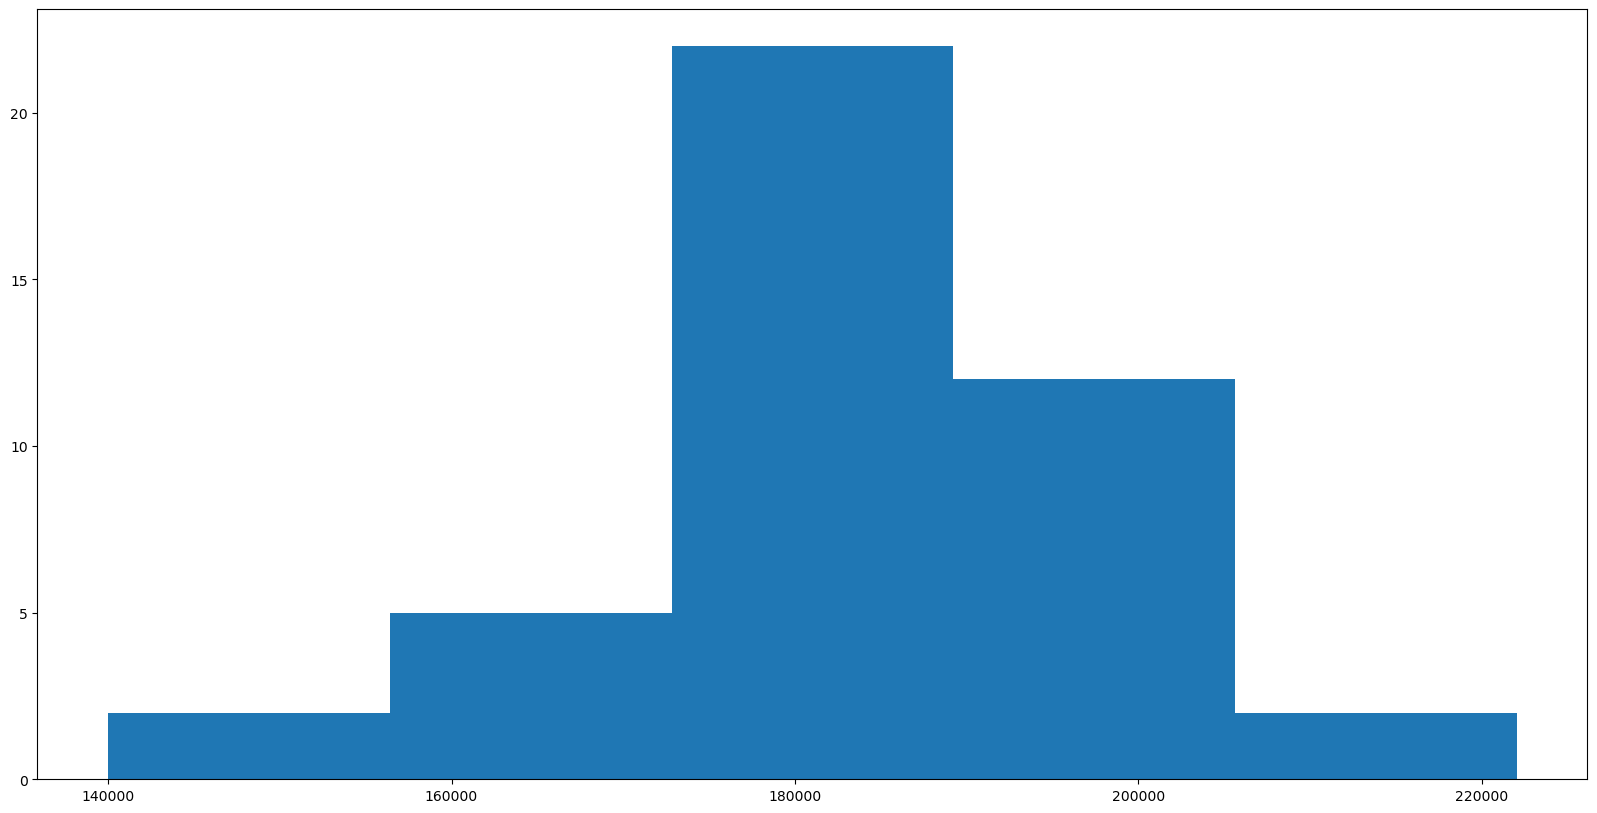

In [32]:
cons_hist(data_frame['MetrosConsumidos'])

In [33]:
# Index 'dataframe' by 'Date'
data_frame_indexed = data_frame.set_index('Date')
data_frame_indexed.head()

,MetrosConsumidos,LecturaActual,LecturaAnterior,Ppt,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM
Date,,,,,,,,,,,,,,,,,
2017-07-01,139987,17692115,17552128,43.4,26.6,15.4,20.2,821.1,811.6,816.9,1.3,97.0,53.0,82.1,1248,319.3,17.2
2017-08-01,222055,17824508,17602453,112.0,27.4,15.3,20.2,821.9,810.2,816.7,1.2,97.0,49.0,82.3,1280,362.0,44.5
2017-09-01,149277,17816058,17666781,144.2,27.9,14.7,19.8,821.8,809.9,816.9,1.3,98.0,43.0,83.3,1311,343.5,58.1
2017-10-01,175709,17898418,17722709,206.4,28.3,13.9,19.5,823.2,809.1,816.5,1.2,98.0,52.0,85.9,1308,322.5,84.0
2017-11-01,175364,18924638,18749274,283.2,26.5,14.7,19.4,822.1,809.2,816.4,1.2,98.0,59.0,87.8,1383,356.9,115.6


In [34]:
data_frame_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2017-07-01 to 2021-09-01
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MetrosConsumidos  43 non-null     int64  
 1   LecturaActual     43 non-null     int64  
 2   LecturaAnterior   43 non-null     int64  
 3   Ppt               43 non-null     float64
 4   TMax              43 non-null     float64
 5   TMin              43 non-null     float64
 6   TPro              43 non-null     float64
 7   PBMax             43 non-null     float64
 8   PBMin             43 non-null     float64
 9   PBMed             43 non-null     float64
 10  VVPro             43 non-null     float64
 11  HRMax             43 non-null     float64
 12  HRMin             43 non-null     float64
 13  HRMed             43 non-null     float64
 14  RSMax             43 non-null     int64  
 15  RSMed             43 non-null     float64
 16  IAM               43 non-n

# Análisis exploratorio inicial

<AxesSubplot:>

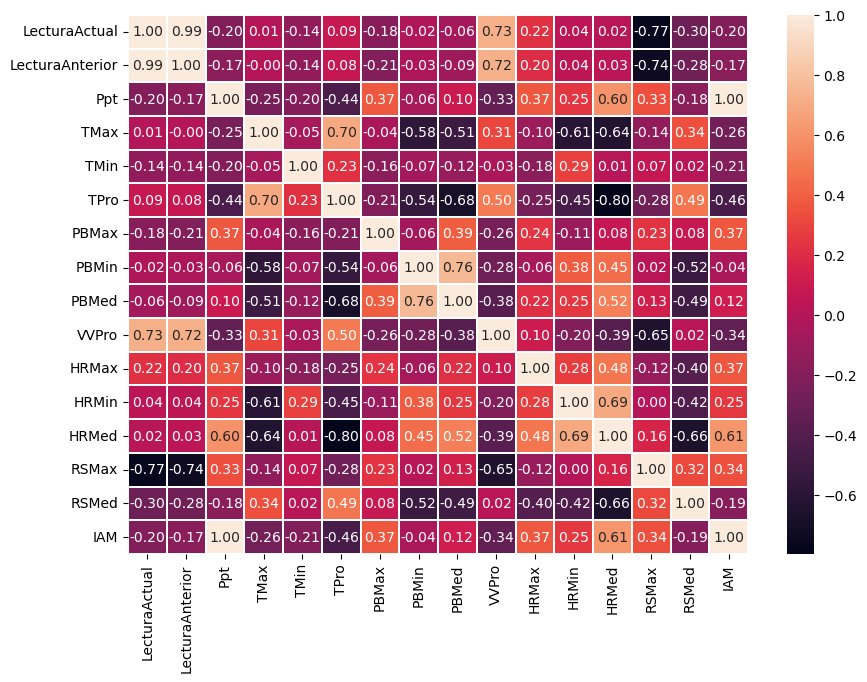

In [35]:
# data_frame_indexed correlation matrix
data_frame_indexed_drop_MS = data_frame_indexed.drop(["MetrosConsumidos"], axis=1)
corr_matrix_data_frame_indexed_drop_MS = data_frame_indexed_drop_MS.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix_data_frame_indexed_drop_MS, annot=True, linewidths=.25, fmt=".2f")

In [36]:
# data_frame_indexed_standard_drop_MS = data_frame_indexed_standard.drop(["MetrosConsumidos"], axis=1)
# corr_matrix_data_frame_indexed_standard_drop_MS = data_frame_indexed_standard_drop_MS.corr()
# plt.figure(figsize=(10,7))
# sns.heatmap(corr_matrix_data_frame_indexed_standard_drop_MS, annot=True, linewidths=.25, fmt=".2f")

In [37]:
# Standadize 'data_frame_indexed'
scaler = StandardScaler()
  
data_frame_indexed_standard = scaler.fit_transform(data_frame_indexed)
data_frame_indexed_standard = pd.DataFrame(data_frame_indexed_standard, columns = ['MetrosConsumidos','LecturaActual','LecturaAnterior',
                                    'Ppt','TMax','TMin','TPro','PBMax','PBMin','PBMed','VVPro',
                                    'HRMax','HRMin','HRMed','RSMax','RSMed','IAM'])
data_frame_indexed_standard.head()

,MetrosConsumidos,LecturaActual,LecturaAnterior,Ppt,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM
0,-2.809576,-2.415793,-2.427593,-1.158483,-0.737203,0.565265,0.294216,-0.796367,1.591094,0.636458,-1.320645,-1.128330,0.274848,-0.500902,0.569254,-0.244612,-1.151745
1,2.659452,-2.253590,-2.367494,-0.226985,-0.141903,0.463137,0.294216,0.132278,0.589171,0.364143,-1.944686,-1.128330,-0.250417,-0.440569,0.780441,0.820693,-0.241162
2,-2.190488,-2.263943,-2.290672,0.210249,0.230160,-0.149629,-0.354568,0.016197,0.374473,0.636458,-1.320645,0.298675,-1.038314,-0.138906,0.985028,0.359144,0.212462
3,-0.429054,-2.163038,-2.223881,1.054843,0.527810,-0.966650,-0.841156,1.641326,-0.198055,0.091827,-1.944686,0.298675,0.143532,0.645420,0.965230,-0.164777,1.076348
4,-0.452045,-0.905747,-0.997931,2.097687,-0.811615,-0.149629,-1.003352,0.364439,-0.126489,-0.044330,-1.944686,0.298675,1.062745,1.218580,1.460200,0.693455,2.130356


In [38]:
data_frame_indexed_standard.describe()

,MetrosConsumidos,LecturaActual,LecturaAnterior,Ppt,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM
count,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01,4.300000e+01
mean,-7.797380e-16,4.802360e-16,-9.294890e-16,4.131062e-17,-1.714391e-15,-2.716174e-15,1.631770e-15,1.627174e-13,1.694768e-14,1.083371e-14,1.136042e-16,-7.017642e-15,4.131062e-17,-2.695518e-15,-3.563041e-16,6.545152e-16,-3.976148e-16
std,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00,1.011835e+00
min,-2.809576e+00,-2.415793e+00,-2.427593e+00,-1.679905e+00,-2.002216e+00,-4.949630e+00,-1.652136e+00,-2.537577e+00,-2.058769e+00,-2.495171e+00,-1.944686e+00,-2.555335e+00,-2.220160e+00,-2.612547e+00,-1.225837e+00,-2.000995e+00,-1.662072e+00
25%,-4.638406e-01,-4.067293e-01,-3.247384e-01,-6.750821e-01,-6.255842e-01,-3.538843e-01,-8.411562e-01,-7.383268e-01,-6.274503e-01,-5.889616e-01,-1.008624e+00,-4.148271e-01,-6.443657e-01,-4.707355e-01,-1.080646e+00,-8.595957e-01,-6.864472e-01
50%,-7.712751e-02,-1.395259e-01,-1.206715e-01,-2.405639e-01,-1.419029e-01,2.588818e-01,-1.923720e-01,-9.988333e-02,1.664324e-02,9.182734e-02,5.514781e-01,2.986755e-01,1.221546e-02,-1.824012e-02,2.590726e-01,6.475035e-02,-2.411621e-01
75%,6.002035e-01,8.409669e-01,7.101060e-01,5.999571e-01,4.533971e-01,5.142010e-01,6.186081e-01,4.805198e-01,6.607368e-01,6.364585e-01,5.514781e-01,2.986755e-01,6.031385e-01,6.303365e-01,7.804409e-01,7.508372e-01,6.327306e-01
max,2.659452e+00,1.553209e+00,1.544245e+00,2.097687e+00,3.801960e+00,1.382286e+00,3.051549e+00,2.453890e+00,1.805792e+00,1.725721e+00,1.799560e+00,3.152686e+00,2.113275e+00,1.701242e+00,2.007966e+00,2.786644e+00,2.130356e+00


<AxesSubplot:title={'center':'Consumo, lectura actual y lectura anterior'}>

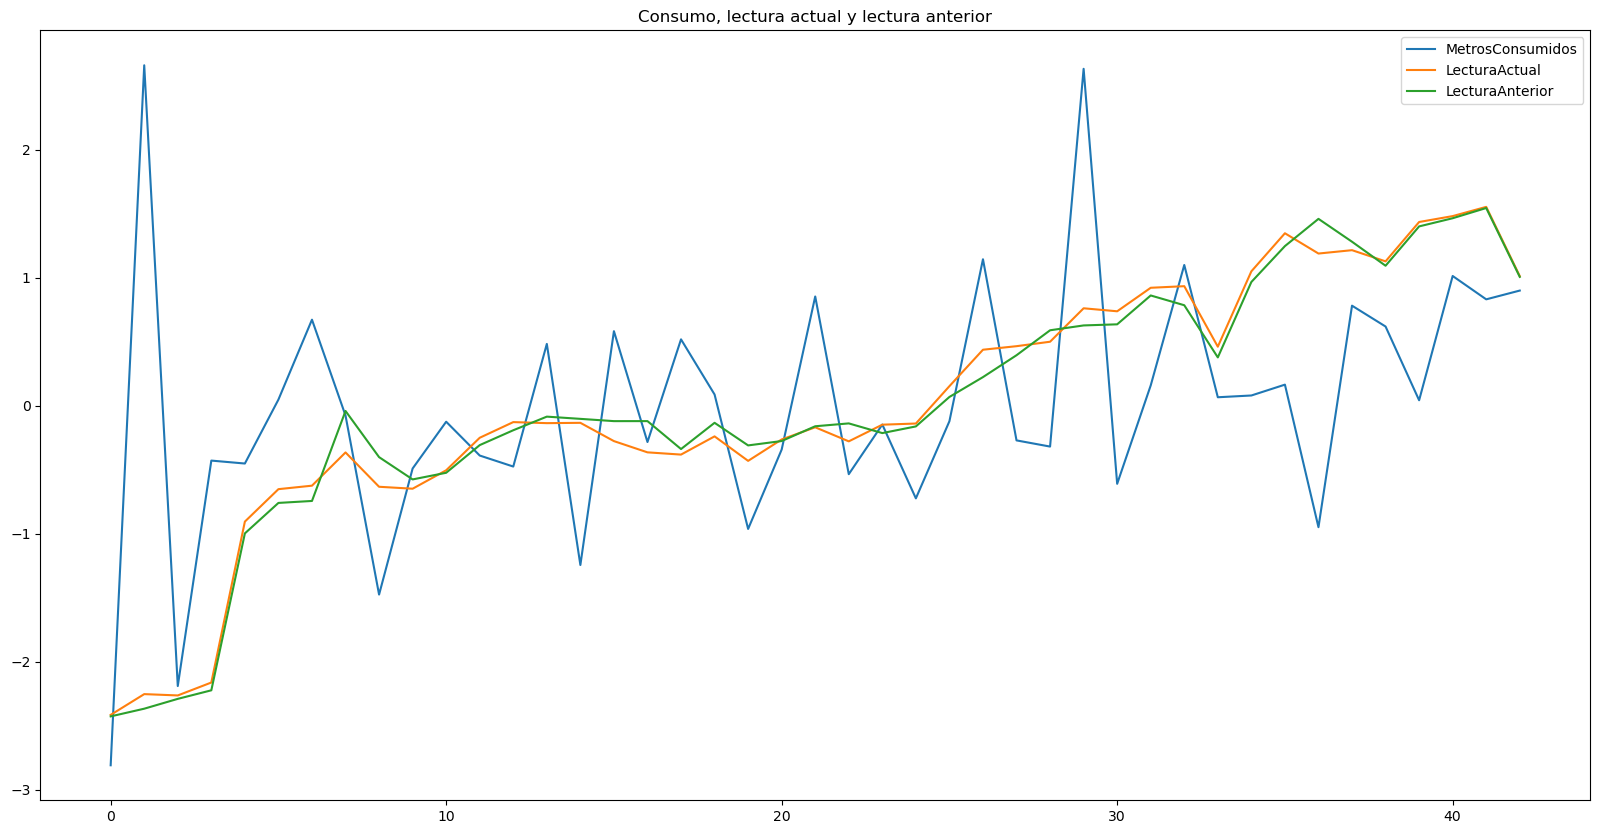

In [39]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','LecturaActual','LecturaAnterior'],
                                title='Consumo, lectura actual y lectura anterior')

<AxesSubplot:title={'center':'Consumo y velocidad del viento'}>

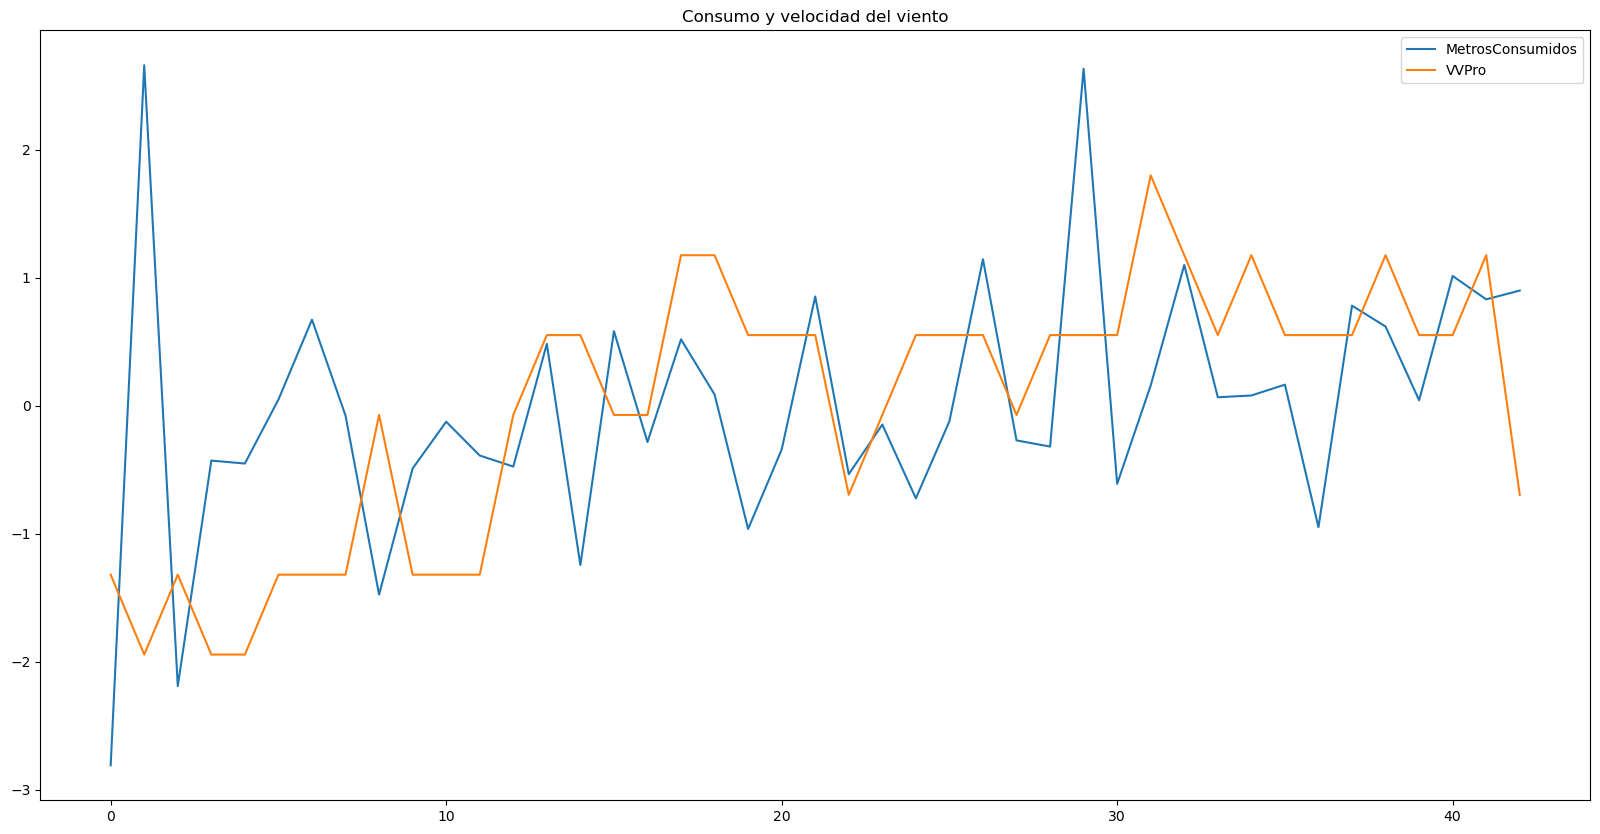

In [40]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','VVPro'],
                                title='Consumo y velocidad del viento')

<AxesSubplot:title={'center':'Consumo, precipitaciones e índice de aridez'}>

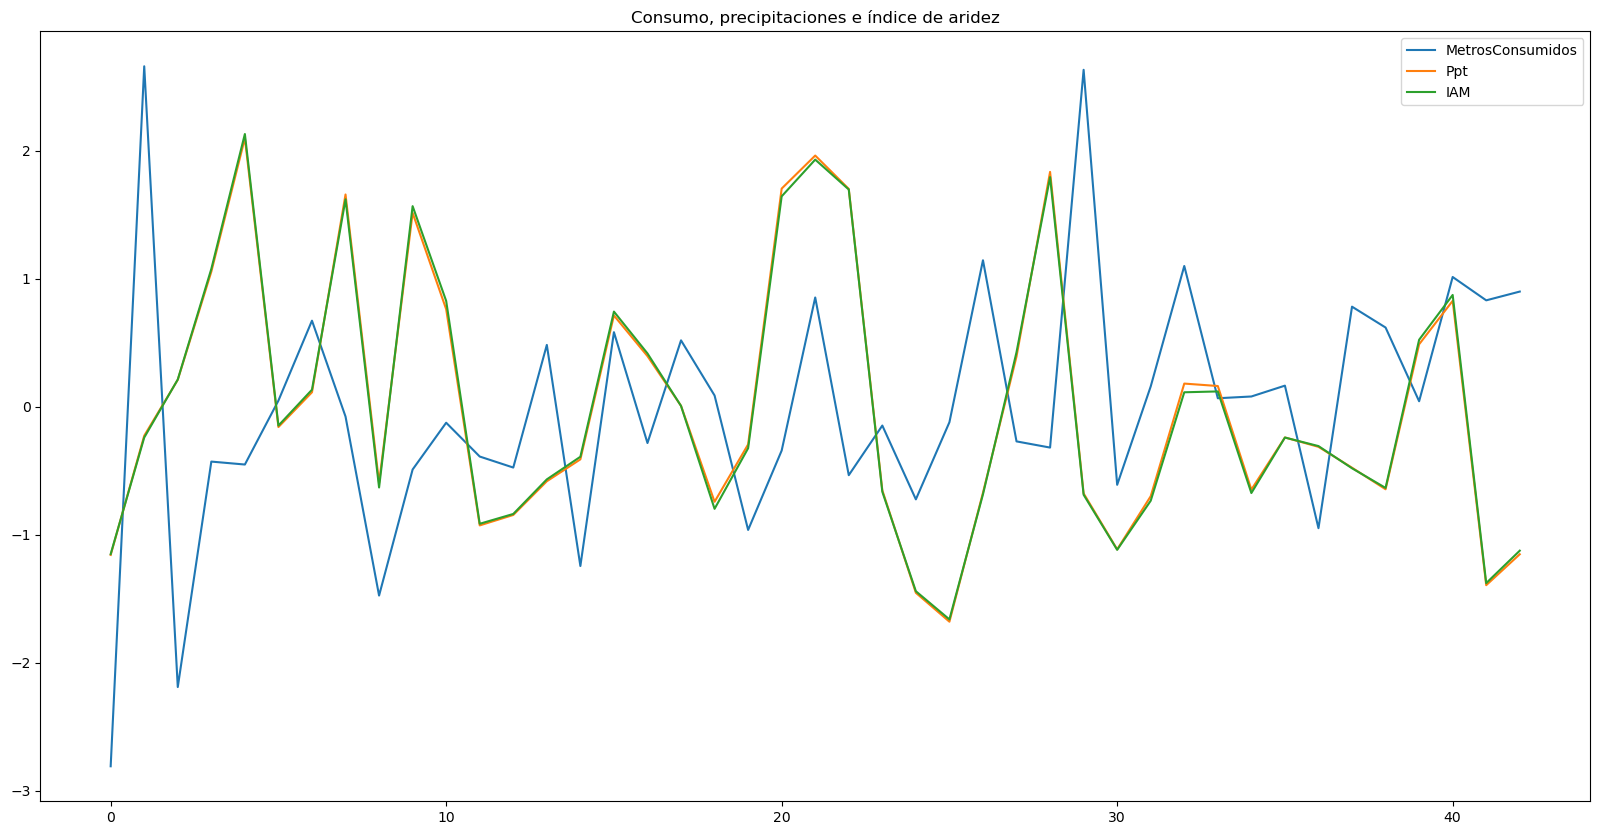

In [41]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','Ppt','IAM'],
                                 title='Consumo, precipitaciones e índice de aridez')

<AxesSubplot:title={'center':'Consumo y temperatura máxima'}>

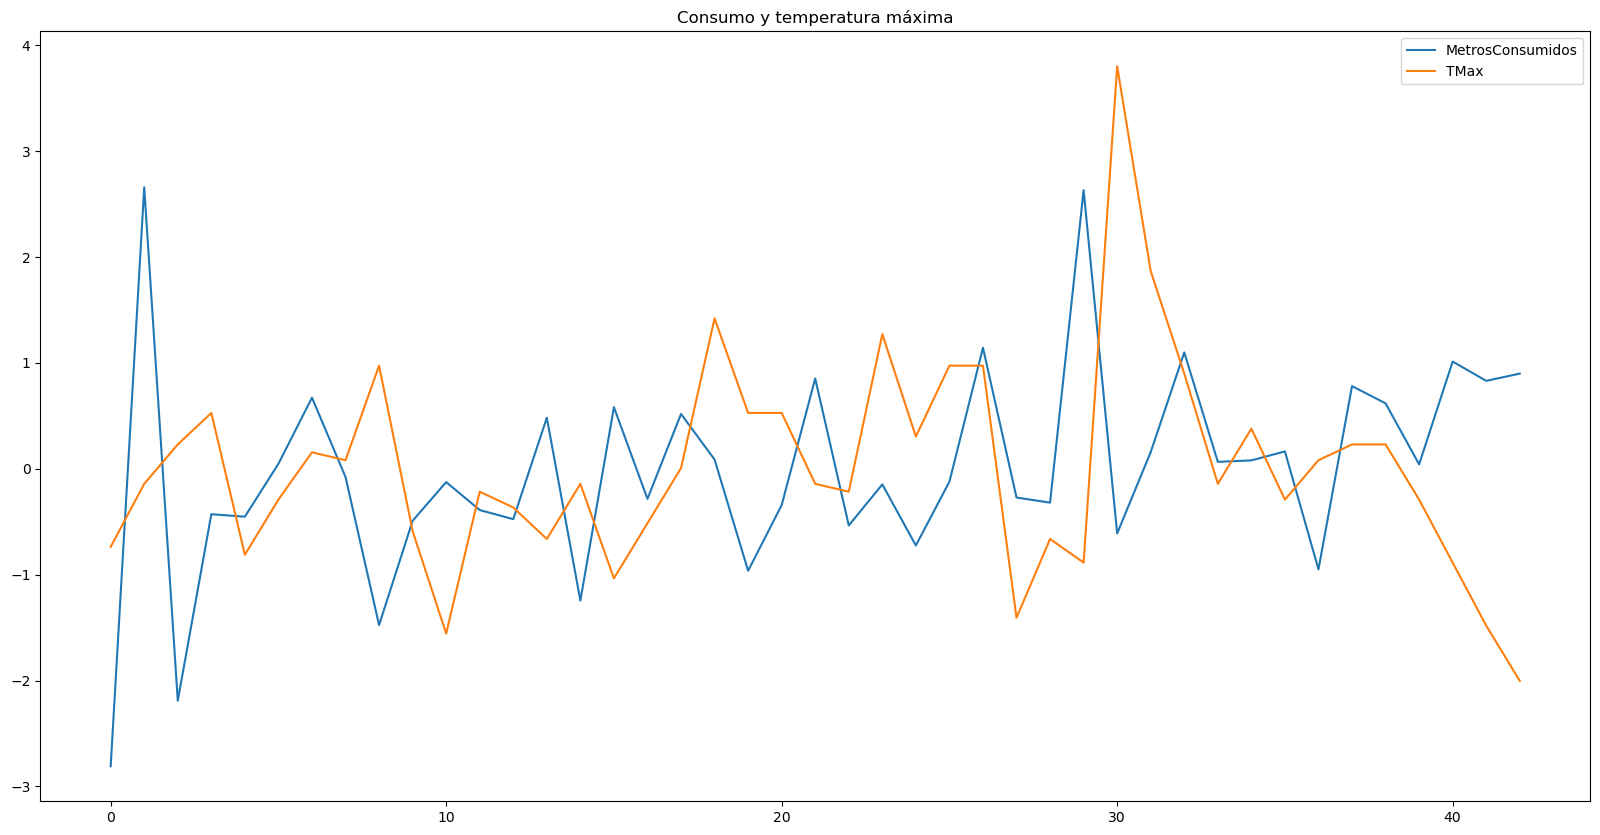

In [42]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','TMax'],
                                title='Consumo y temperatura máxima')

<AxesSubplot:title={'center':'Consumo y temperatura mínima'}>

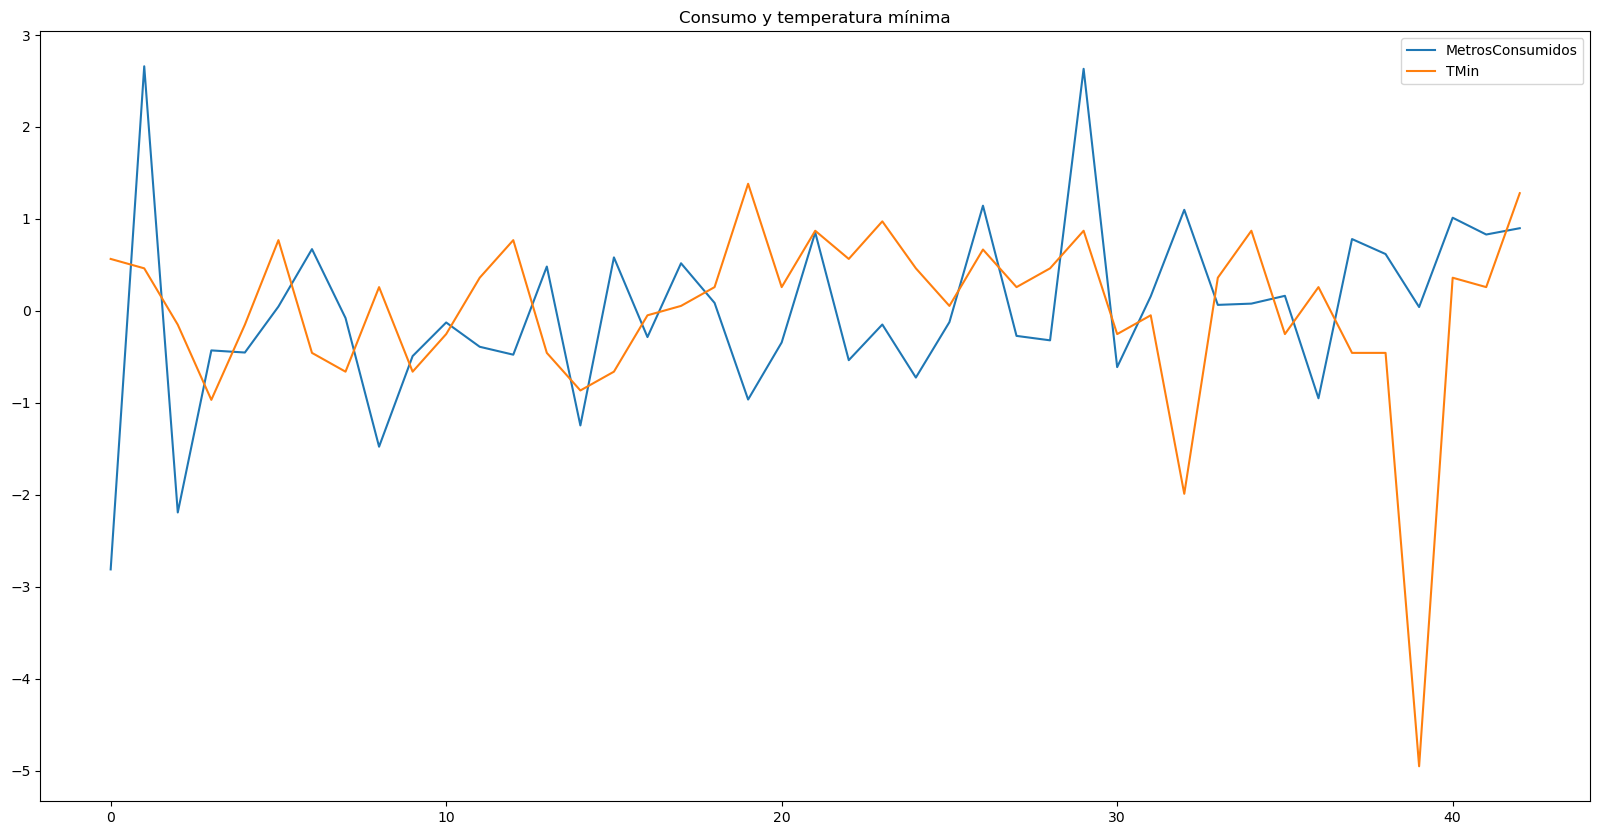

In [43]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','TMin'],
                                title='Consumo y temperatura mínima')

<AxesSubplot:title={'center':'Consumo y temperatura promedio'}>

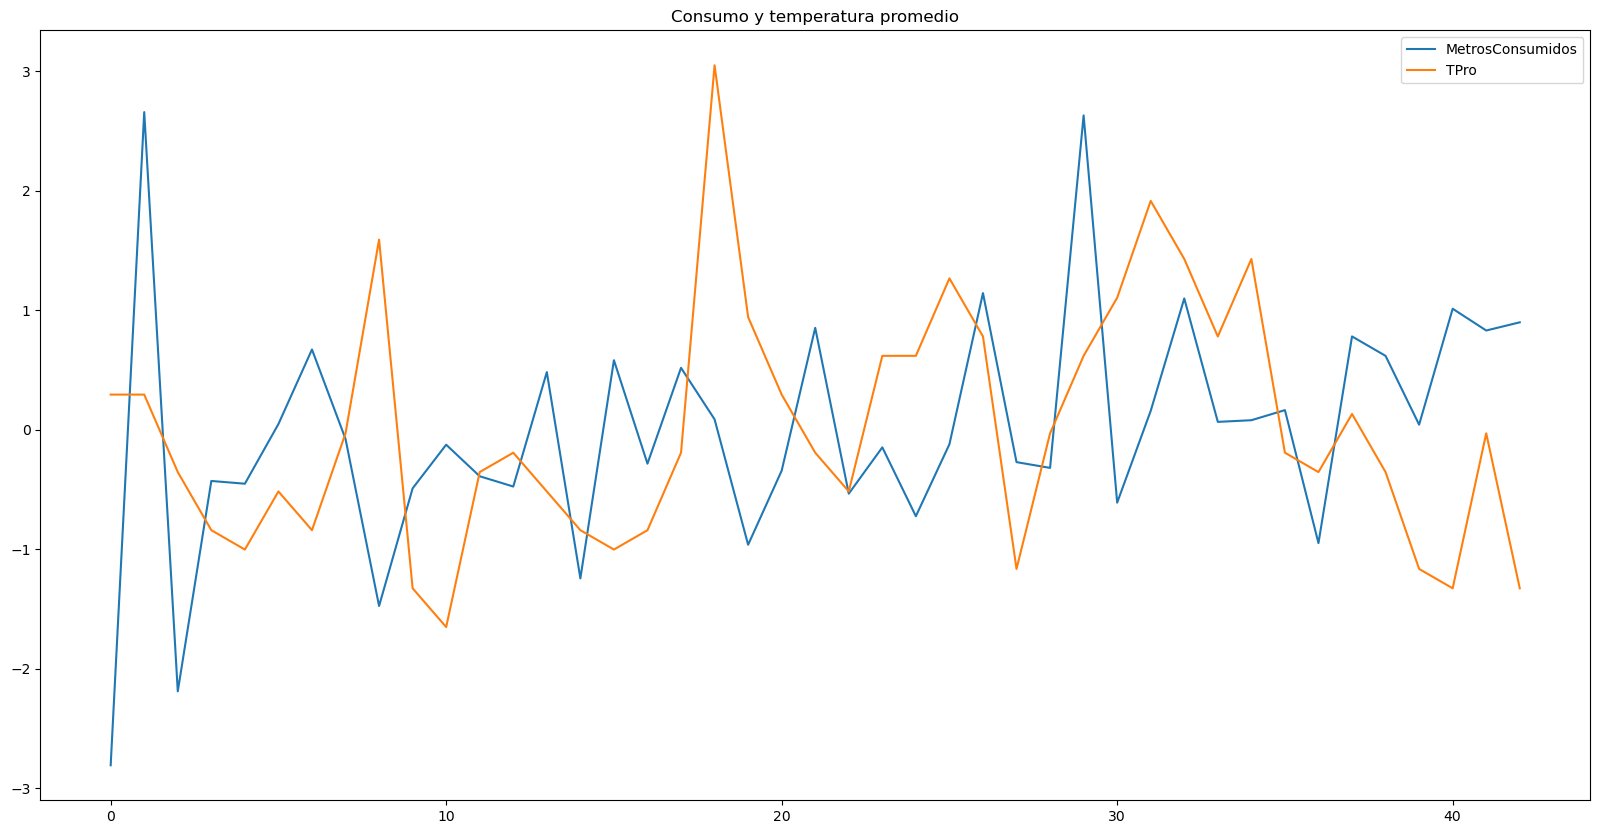

In [44]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','TPro'],
                                title='Consumo y temperatura promedio')

<AxesSubplot:title={'center':'Consumo y presión barométrica máxima'}>

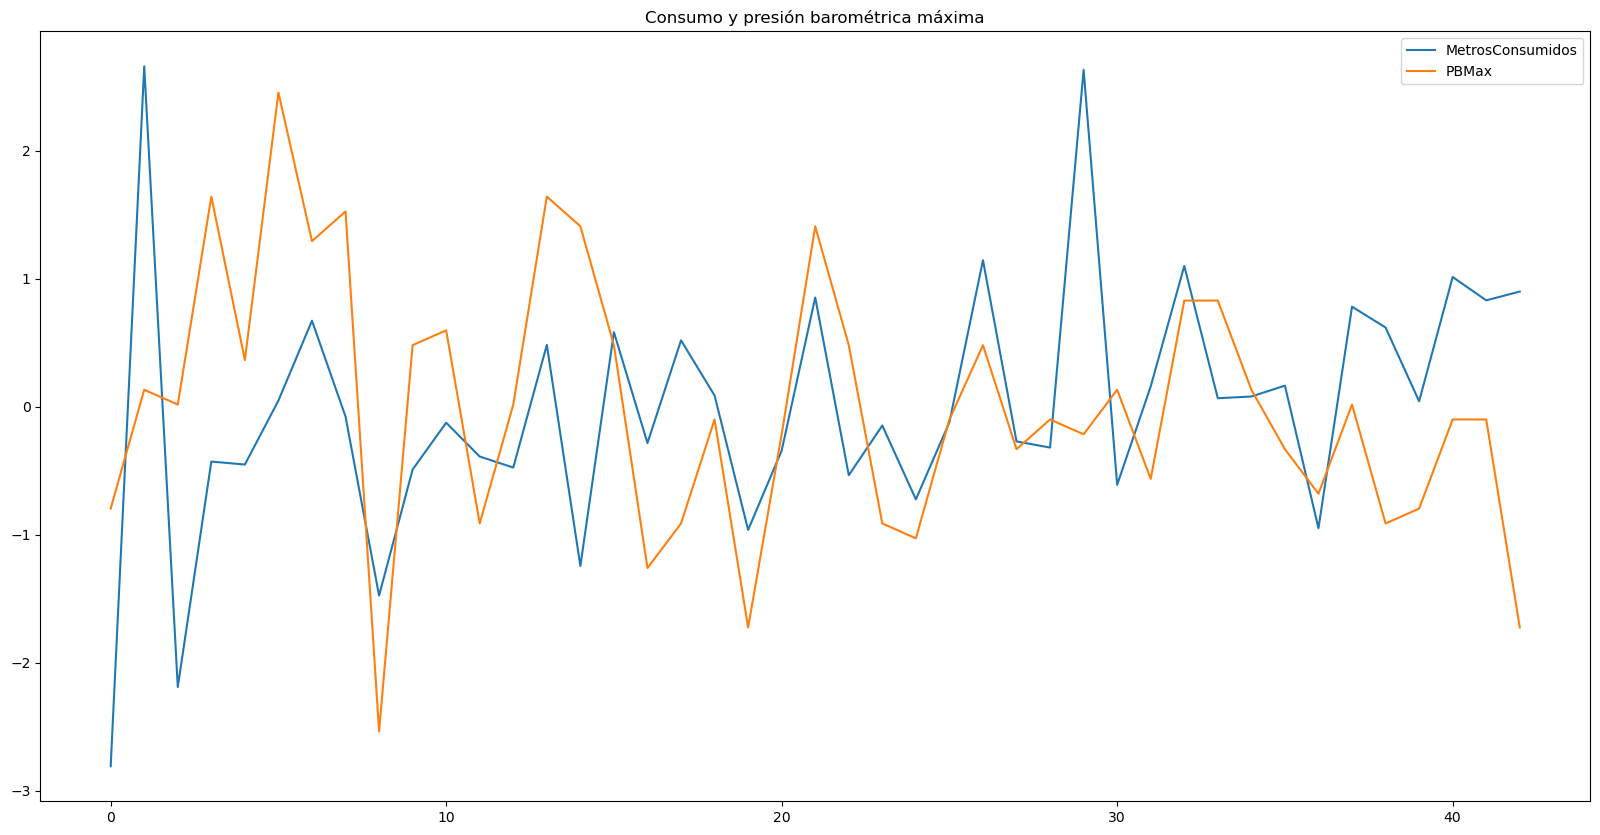

In [96]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','PBMax'],
                                   title='Consumo y presión barométrica máxima')

<AxesSubplot:title={'center':'Consumo y presión barométrica mínima'}>

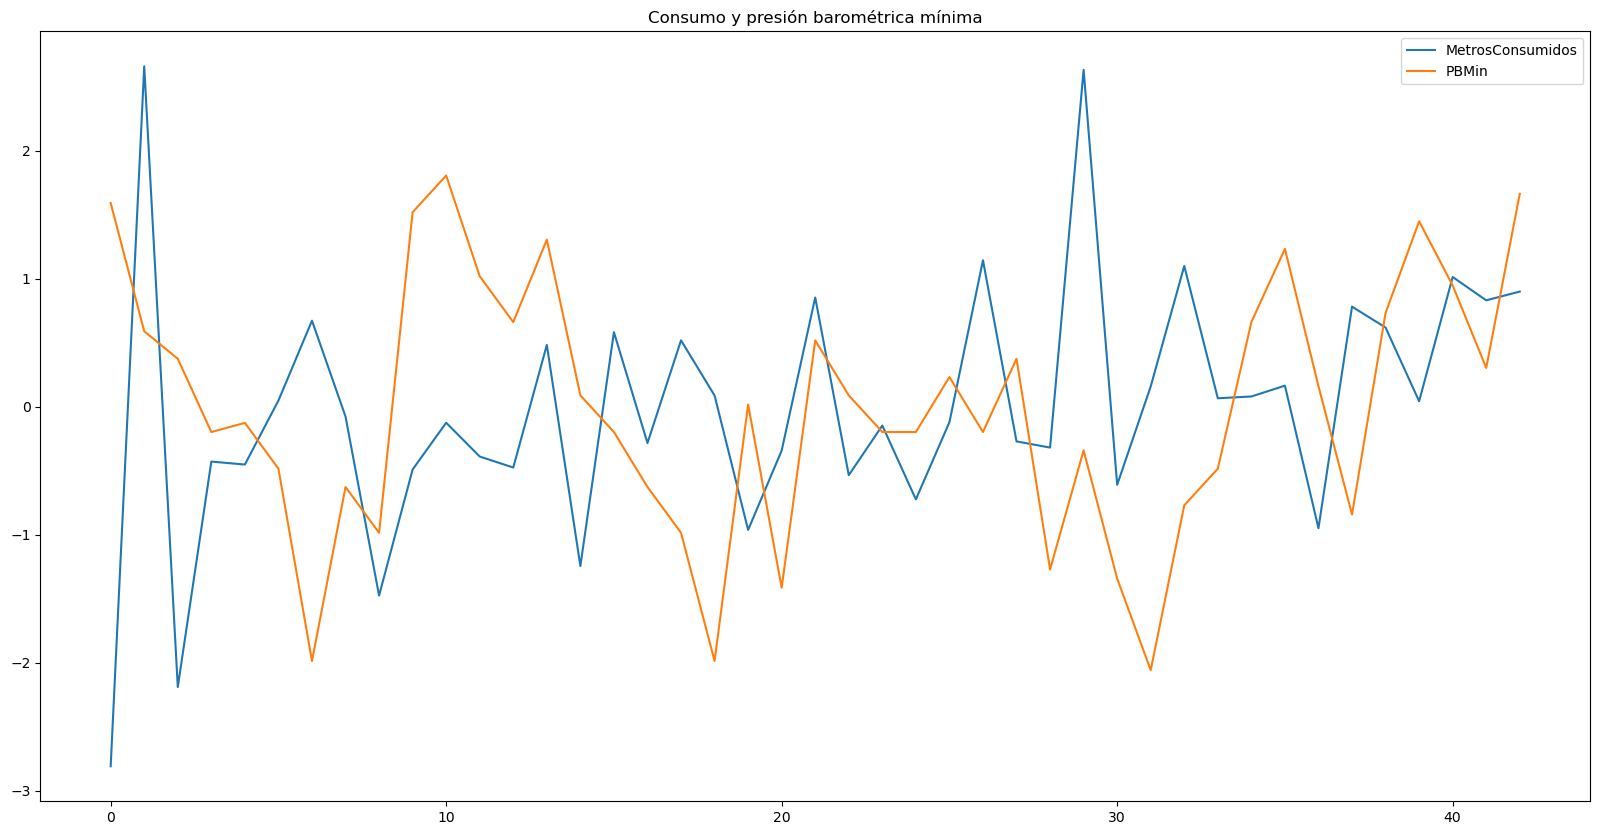

In [97]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','PBMin'],
                                title='Consumo y presión barométrica mínima')

<AxesSubplot:title={'center':'Consumo y presión barométrica media'}>

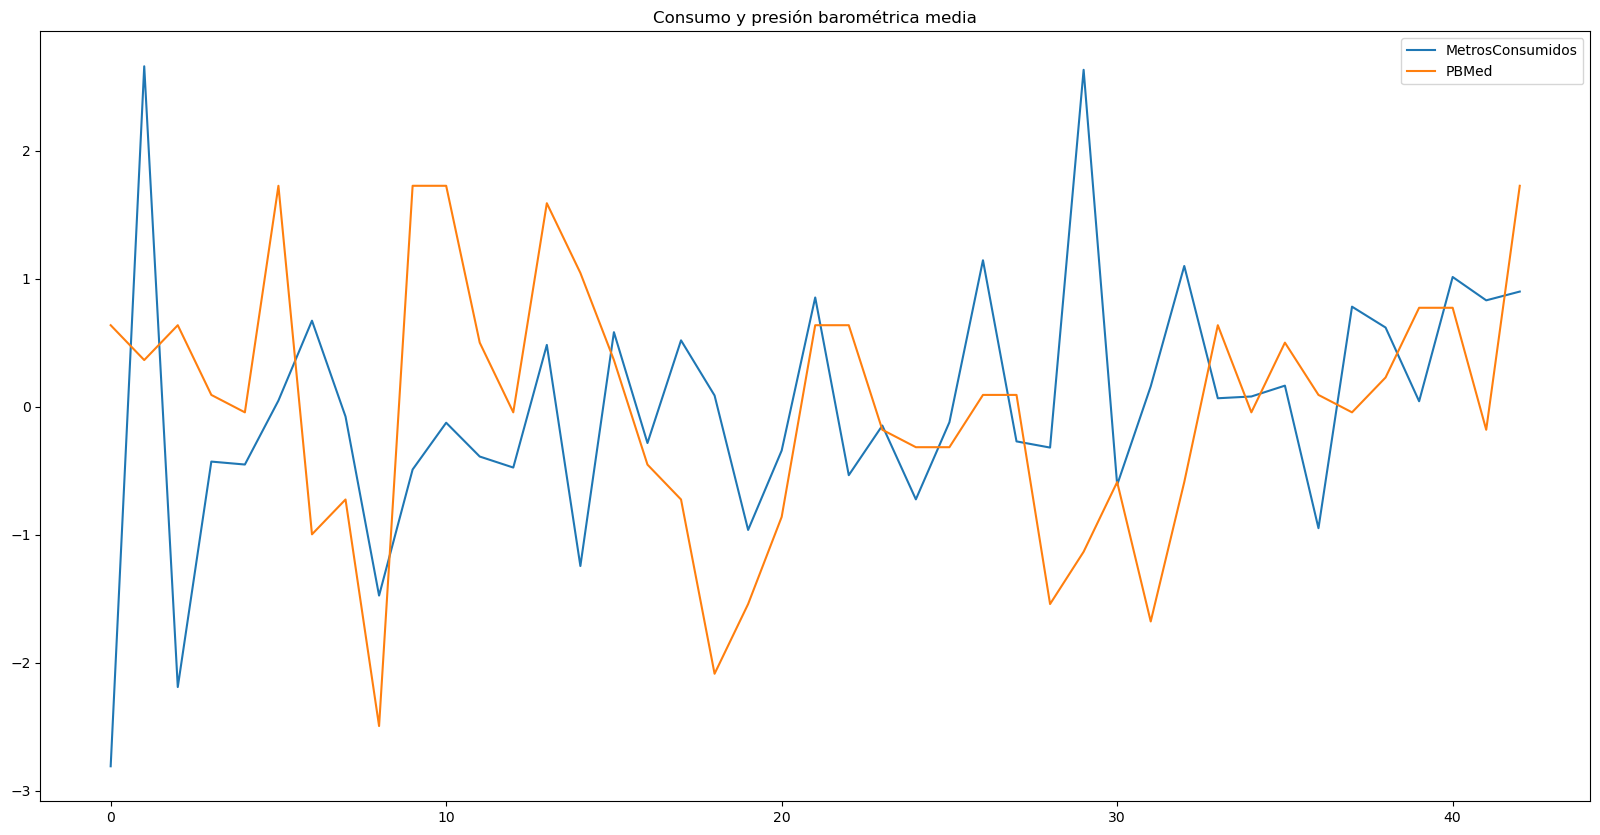

In [98]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','PBMed'],
                                title='Consumo y presión barométrica media')

<AxesSubplot:title={'center':'Consumo y velocidad del viento promedio'}>

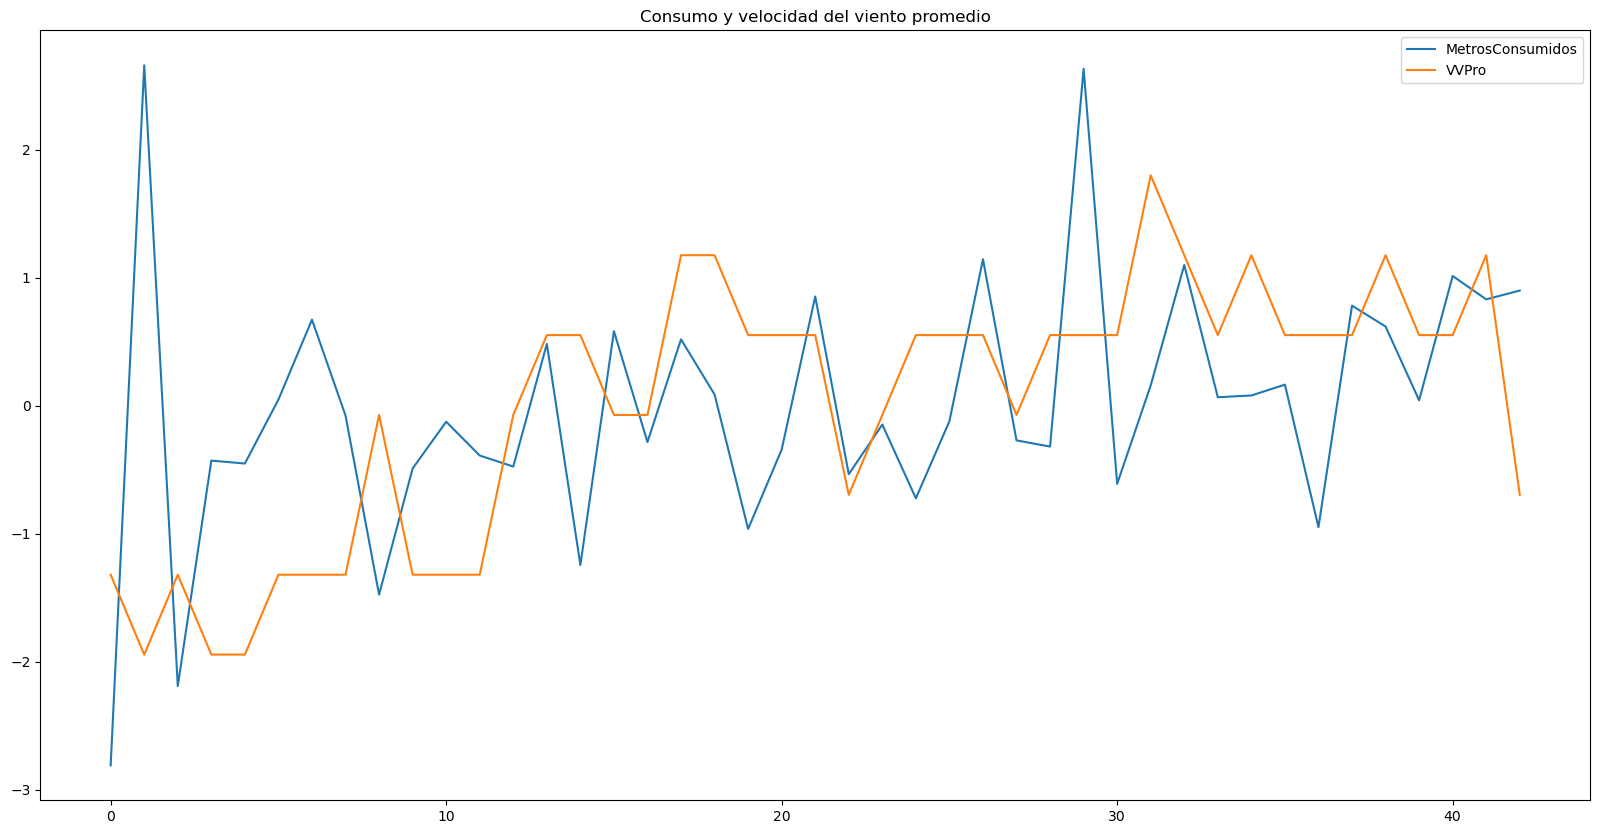

In [99]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','VVPro'],
                                title='Consumo y velocidad del viento promedio')

<AxesSubplot:title={'center':'Consumo y humedad relativa máxima'}>

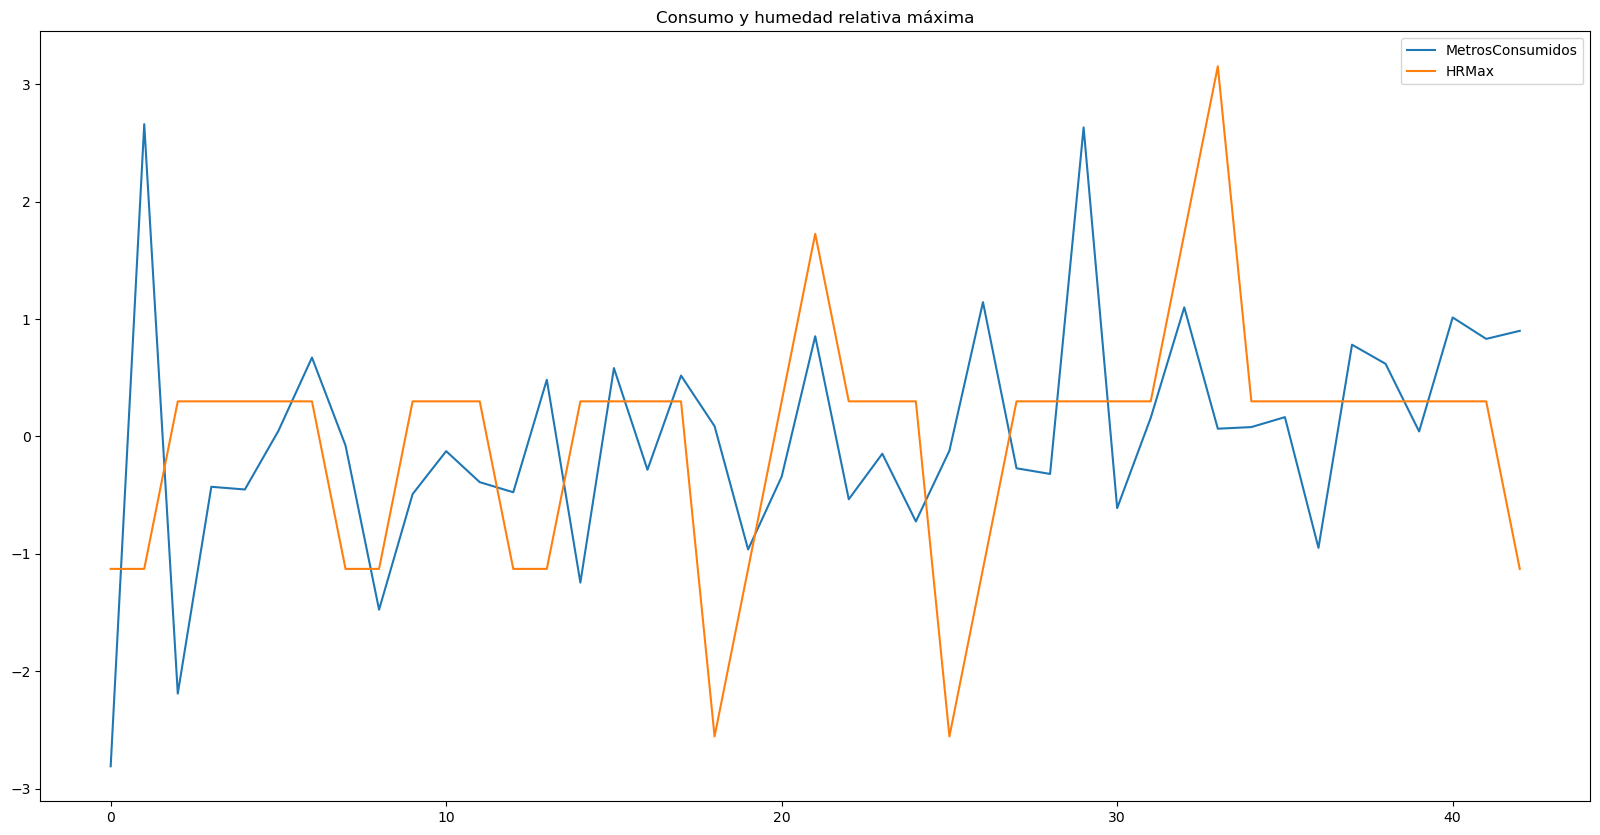

In [101]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','HRMax'],
                                   title='Consumo y humedad relativa máxima')

<AxesSubplot:title={'center':'Consumo y humedad relativa mínima'}>

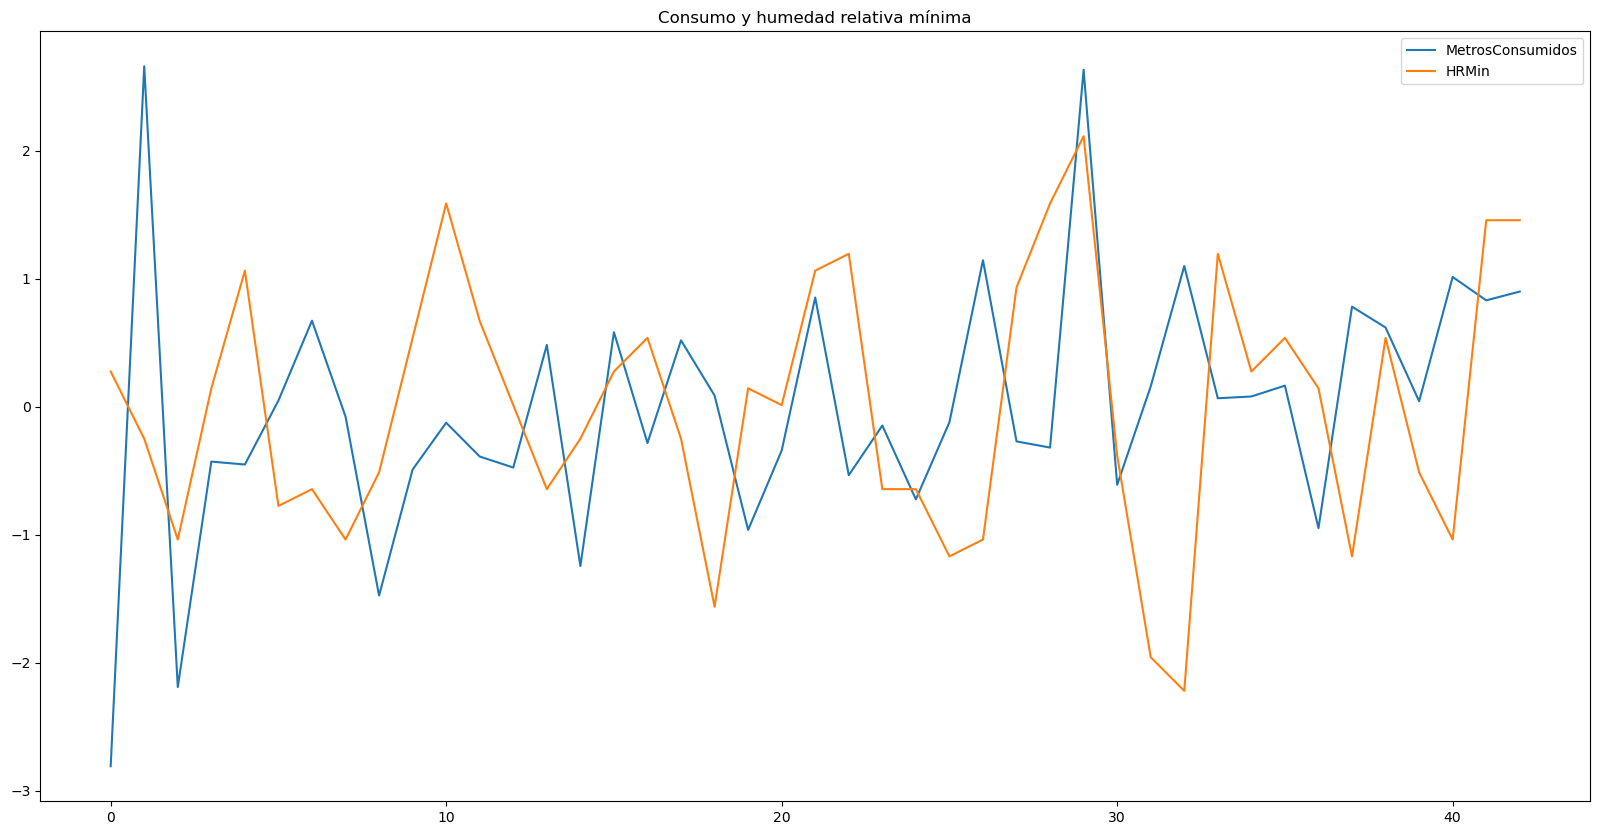

In [102]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','HRMin'],
                                   title='Consumo y humedad relativa mínima')

<AxesSubplot:title={'center':'Consumo y humedad relativa media'}>

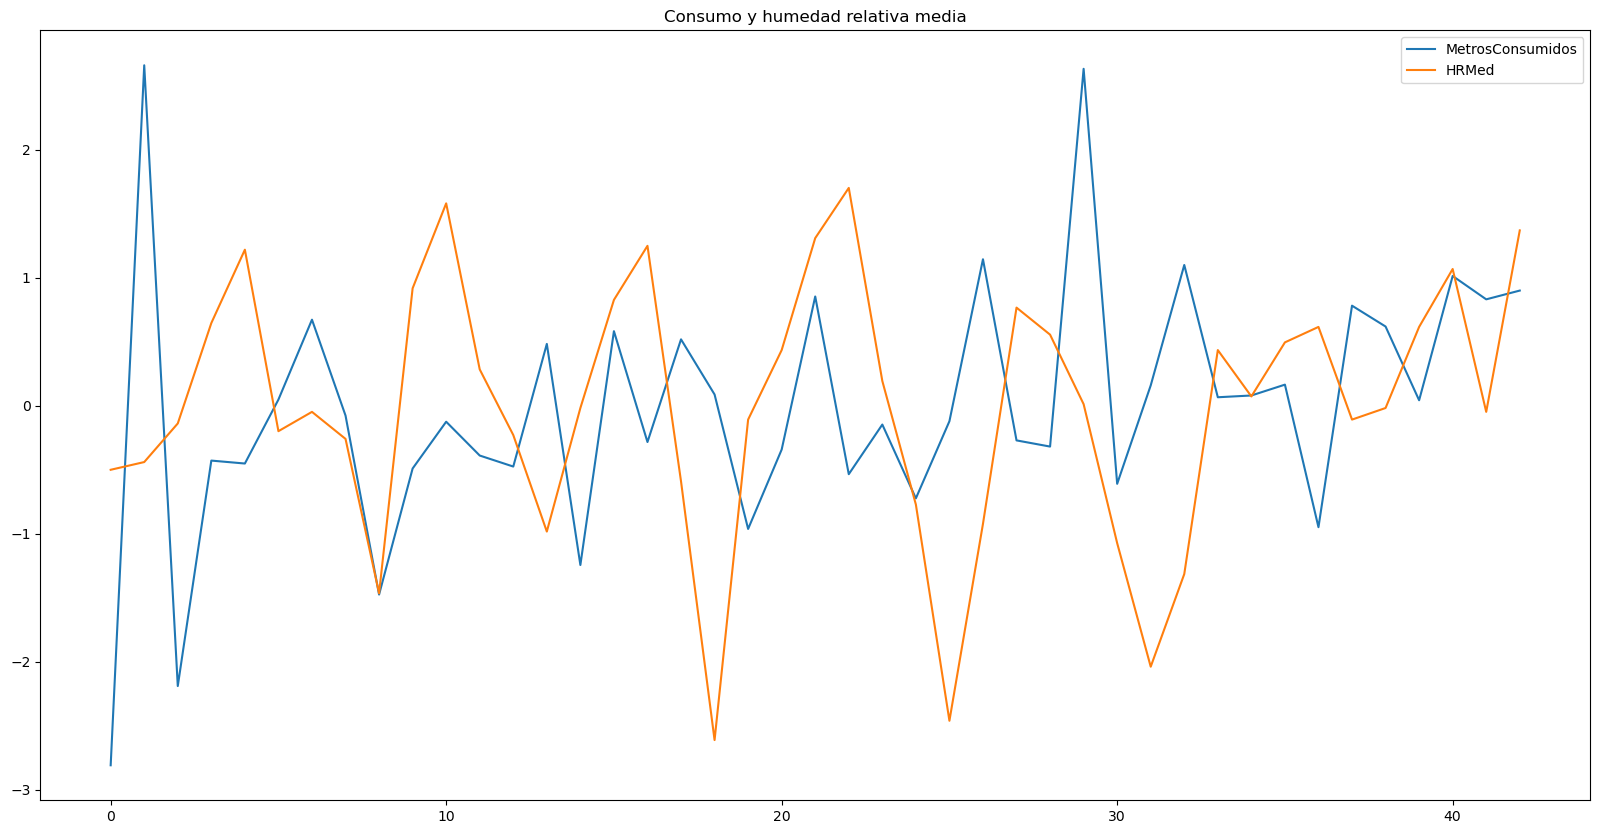

In [103]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','HRMed'],
                                title='Consumo y humedad relativa media')

<AxesSubplot:title={'center':'Consumo y radiación solar máxima'}>

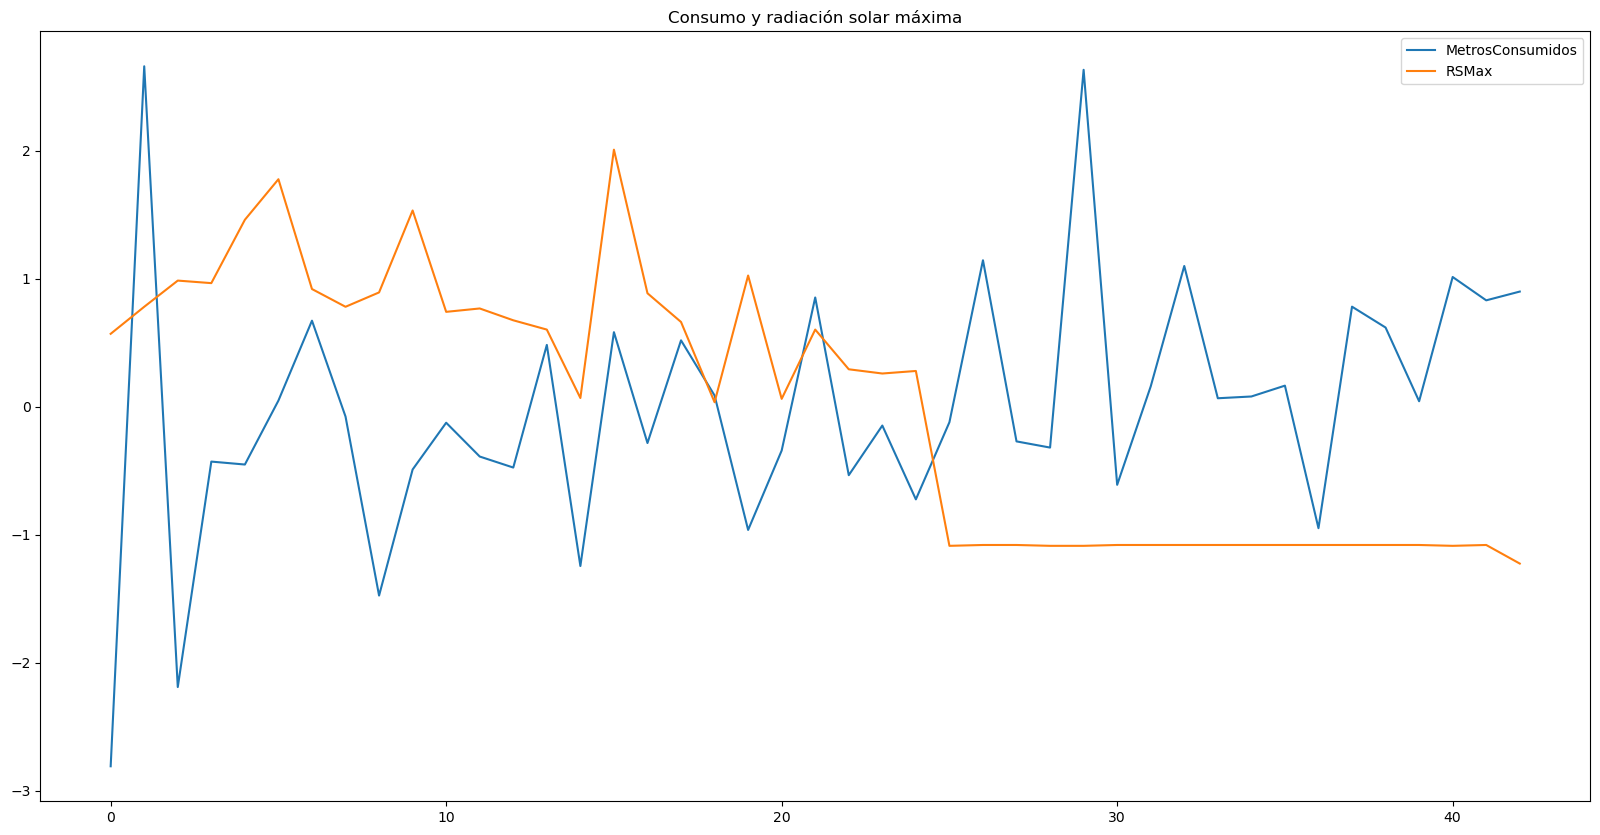

In [104]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','RSMax'],
                                   title='Consumo y radiación solar máxima')

<AxesSubplot:title={'center':'Consumo y radiación solar media'}>

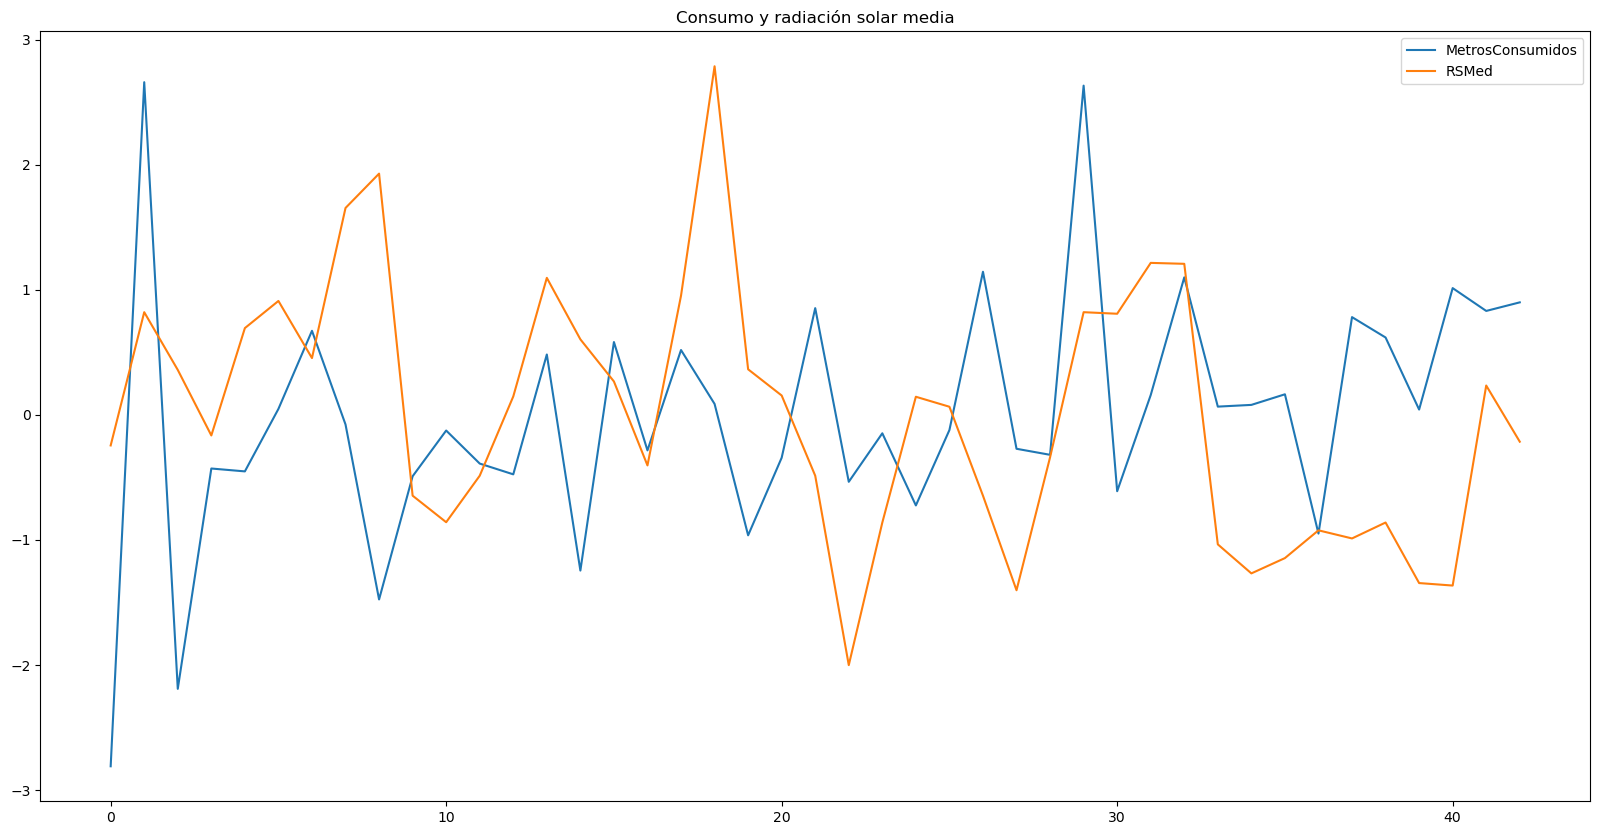

In [105]:
data_frame_indexed_standard.plot(y=['MetrosConsumidos','RSMed'],
                                   title='Consumo y radiación solar media')

In [106]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2017-07-01 to 2021-09-01
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              43 non-null     datetime64[ns]
 1   MetrosConsumidos  43 non-null     int64         
 2   LecturaActual     43 non-null     int64         
 3   LecturaAnterior   43 non-null     int64         
 4   Ppt               43 non-null     float64       
 5   TMax              43 non-null     float64       
 6   TMin              43 non-null     float64       
 7   TPro              43 non-null     float64       
 8   PBMax             43 non-null     float64       
 9   PBMin             43 non-null     float64       
 10  PBMed             43 non-null     float64       
 11  VVPro             43 non-null     float64       
 12  HRMax             43 non-null     float64       
 13  HRMin             43 non-null     float64       
 14  HRMed   

## Relación existente entre precipitaciones y consumo

In [107]:
def relation_ppt_cons(ppt, means):
  plt.scatter(ppt, means, alpha=1)
  plt.title("Precipitaciones contra Consumo")
  plt.show()
  return np.corrcoef(ppt, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

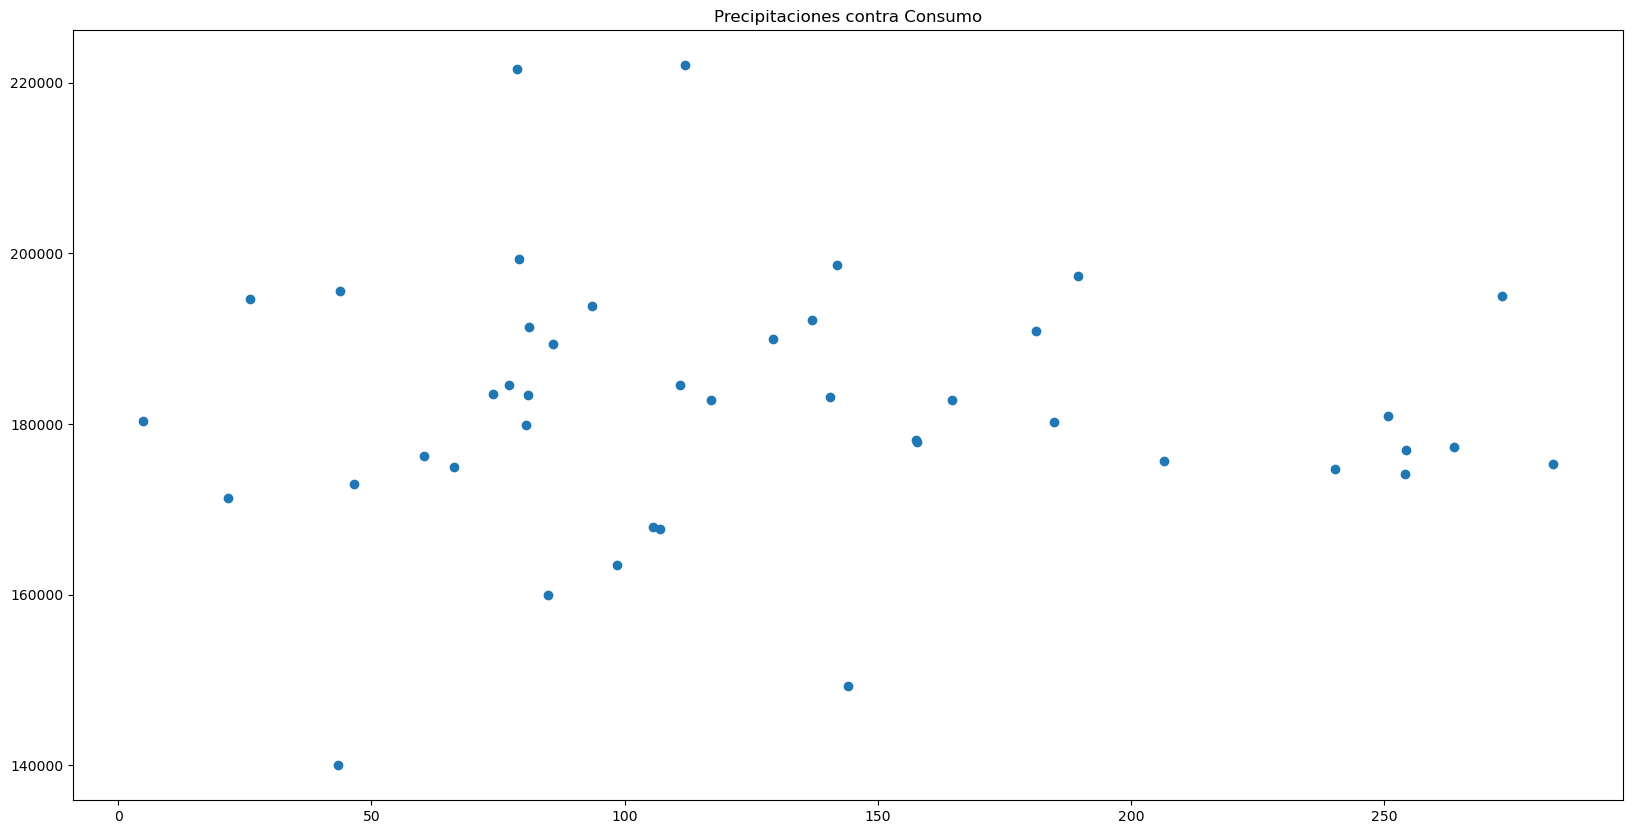

La correlación de Precipitaciones y Consumo es: -0.012652730297323101


In [108]:
print("La correlación de Precipitaciones y Consumo es:", relation_ppt_cons(data_frame['Ppt'], data_frame['MetrosConsumidos']))

## Relación existente entre temperatura máxima y consumo

In [109]:
def relation_tempmax_cons(tempmax, means):
  plt.scatter(tempmax, means, alpha=1)
  plt.title("Temperatura máxima contra Consumo")
  plt.show()
  return np.corrcoef(tempmax, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

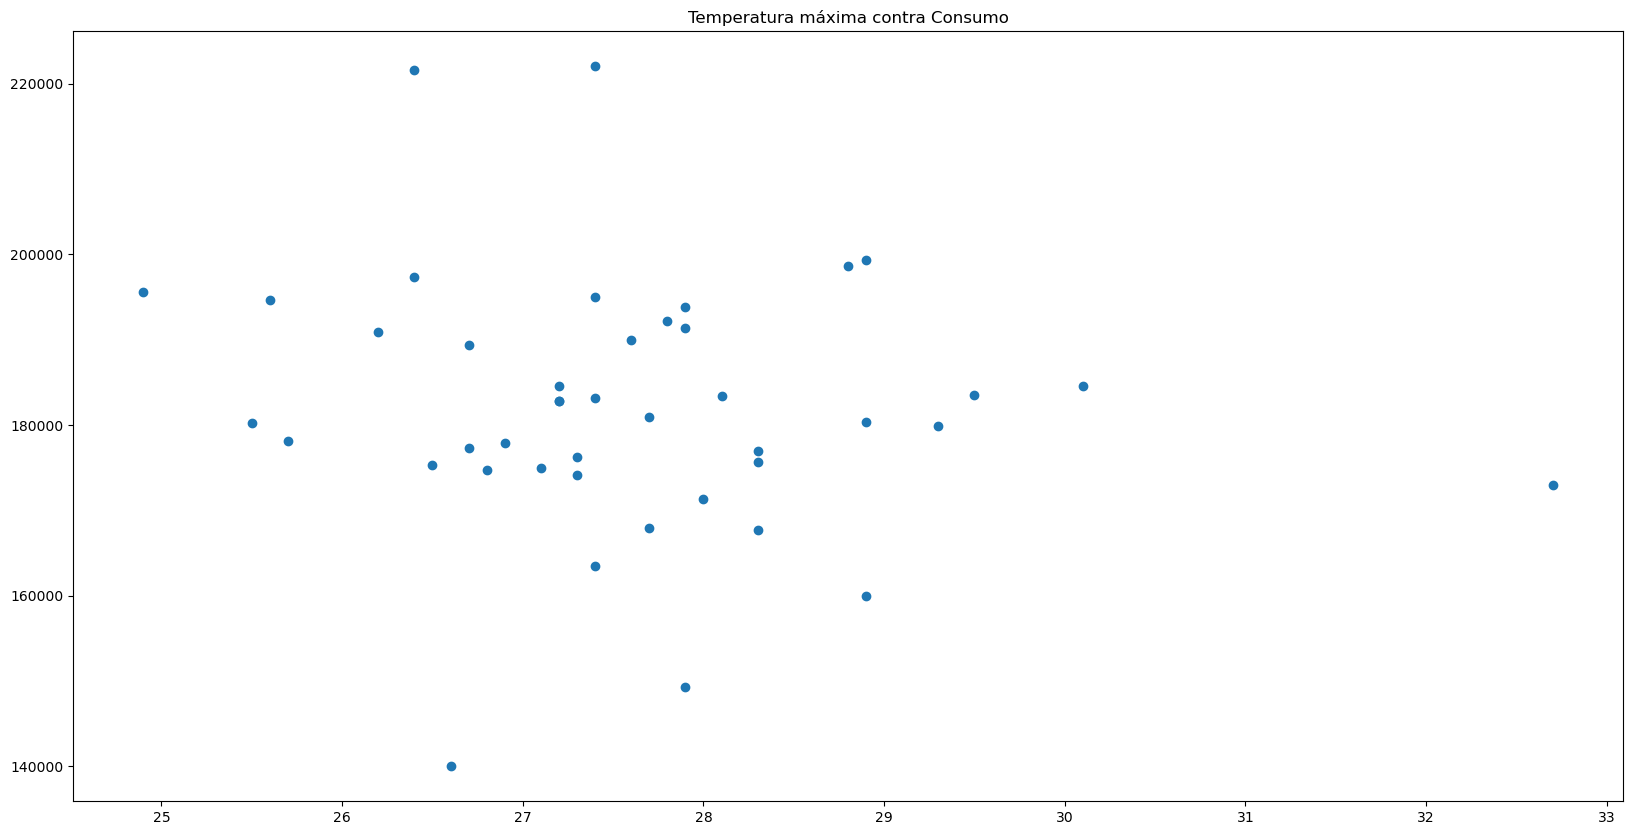

La correlación de Temperatura máxima y Consumo es: -0.14786232879992486


In [110]:
print("La correlación de Temperatura máxima y Consumo es:", relation_tempmax_cons(data_frame['TMax'], data_frame['MetrosConsumidos']))

## Relación existente entre temperatura mínima y consumo

In [111]:
def relation_tempmin_cons(tempmin, means):
  plt.scatter(tempmin, means, alpha=1)
  plt.title("Temperatura mínima contra Consumo")
  plt.show()
  return np.corrcoef(tempmin, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

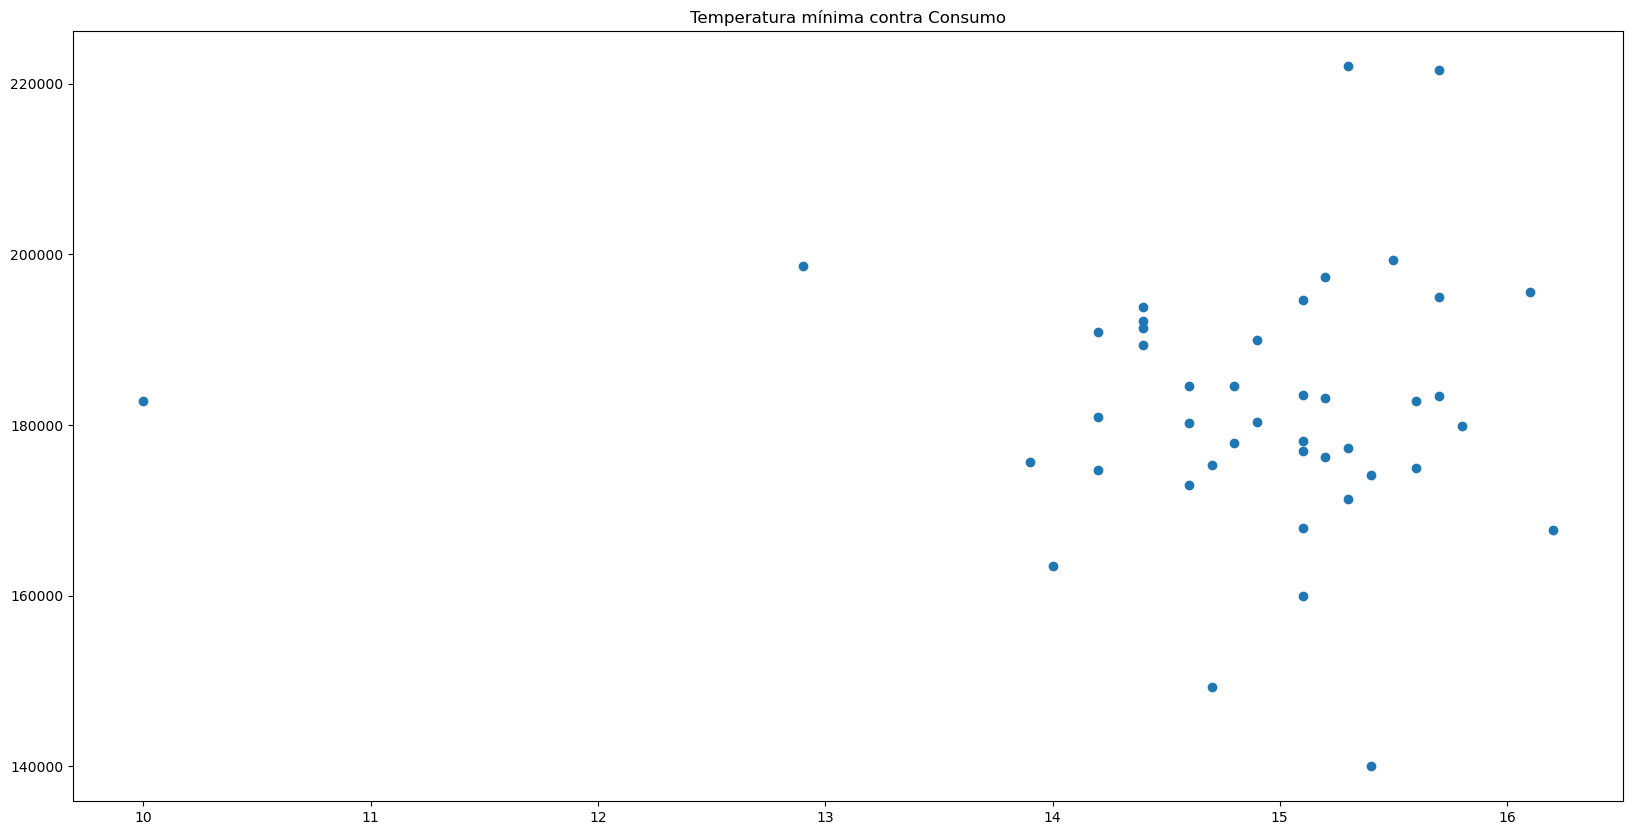

La correlación de Temperatura mínima y Consumo es: 0.006149216377884671


In [112]:
print("La correlación de Temperatura mínima y Consumo es:", relation_tempmin_cons(data_frame['TMin'], data_frame['MetrosConsumidos']))

## Relación existente entre temperatura promedio y consumo

In [113]:
def relation_temppro_cons(temppro, means):
  plt.scatter(temppro, means, alpha=1)
  plt.title("Temperatura promedio contra Consumo")
  plt.show()
  return np.corrcoef(temppro, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

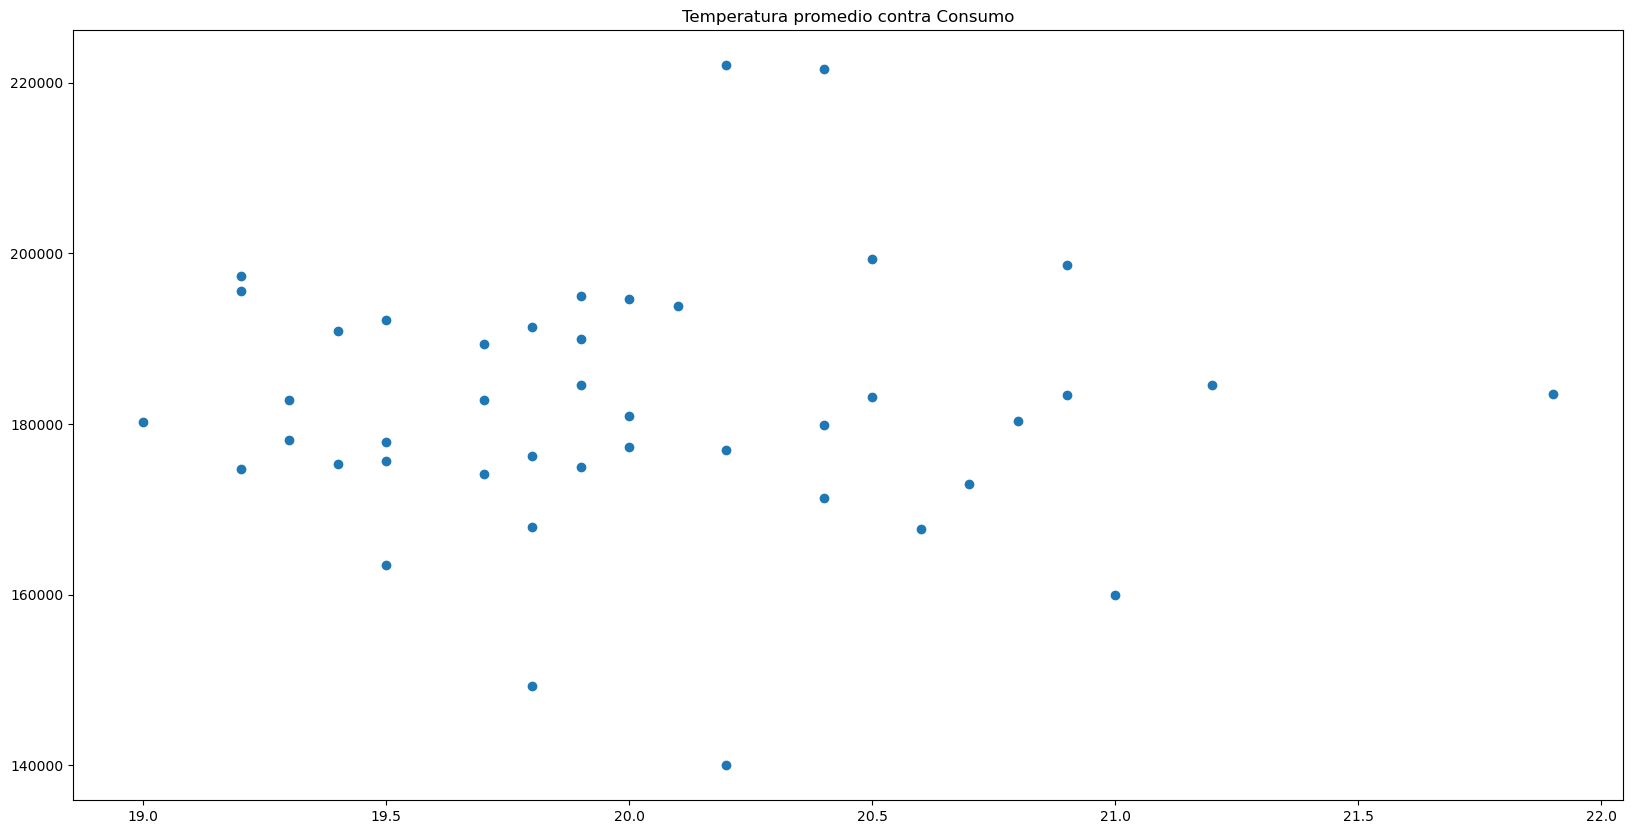

La correlación de Temperatura promedio y Consumo es: 0.012005288494017706


In [114]:
print("La correlación de Temperatura promedio y Consumo es:", relation_temppro_cons(data_frame['TPro'], data_frame['MetrosConsumidos']))

## Relación existente entre presión barométrica máxima y consumo

In [117]:
def relation_pbrmax_cons(pbrmax, means):
  plt.scatter(pbrmax, means, alpha=1)
  plt.title("Presión barométrica máxima contra Consumo")
  plt.show()
  return np.corrcoef(pbrmax, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

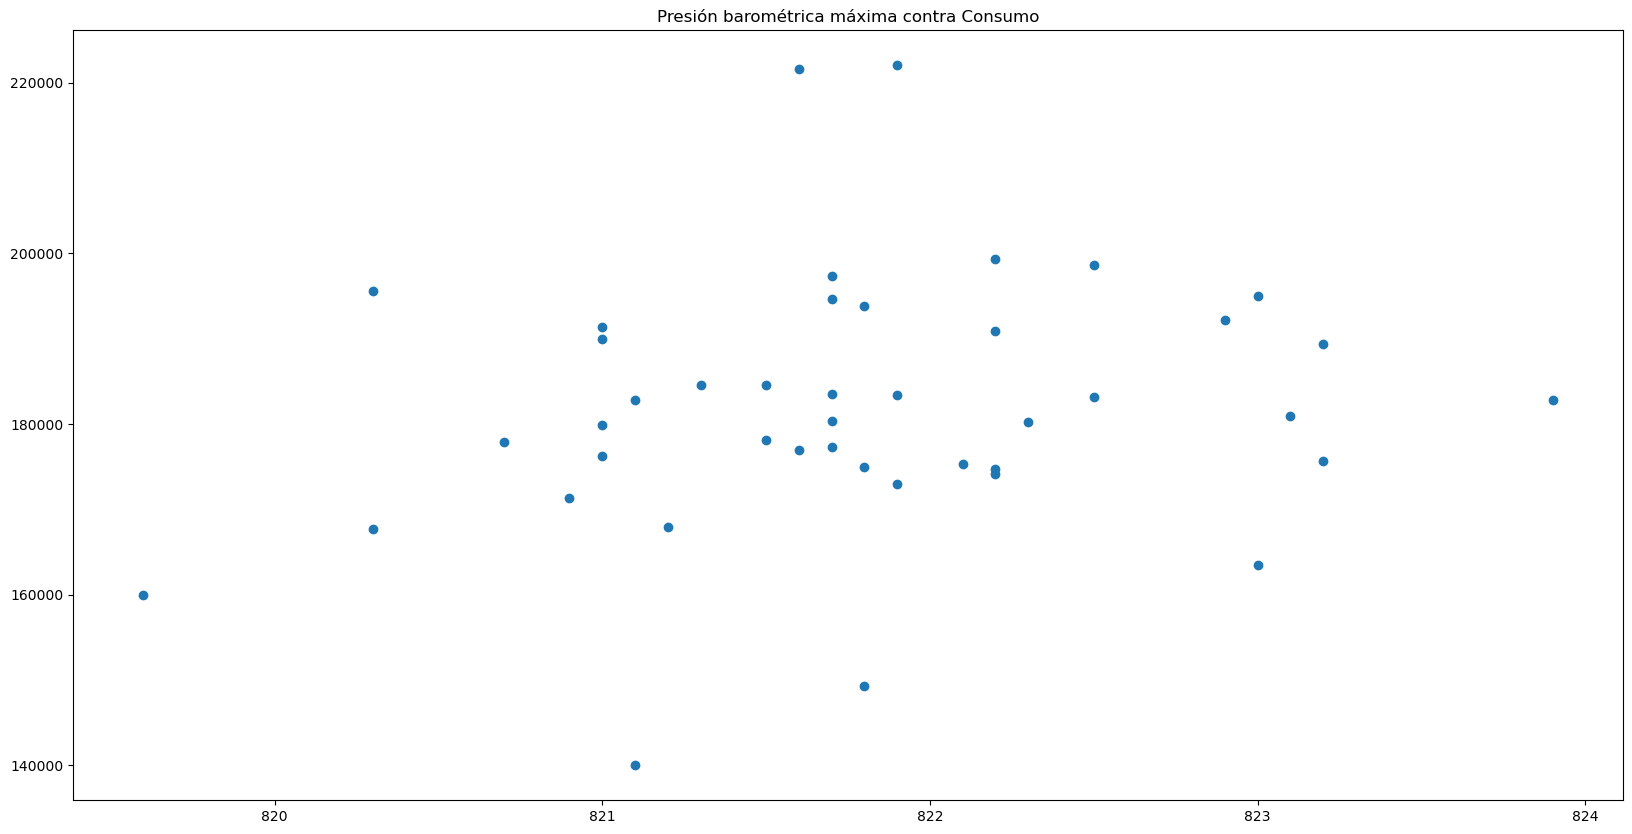

La correlación de Presión barométrica máxima y Consumo es: 0.1925661198186365


In [118]:
print("La correlación de Presión barométrica máxima y Consumo es:", relation_pbrmax_cons(data_frame['PBMax'], data_frame['MetrosConsumidos']))

## Relación existente entre presión barométrica mínima y consumo

In [119]:
def relation_pbrmin_cons(pbrmin, means):
  plt.scatter(pbrmin, means, alpha=1)
  plt.title("Presión barométrica mínima contra Consumo")
  plt.show()
  return np.corrcoef(pbrmin, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

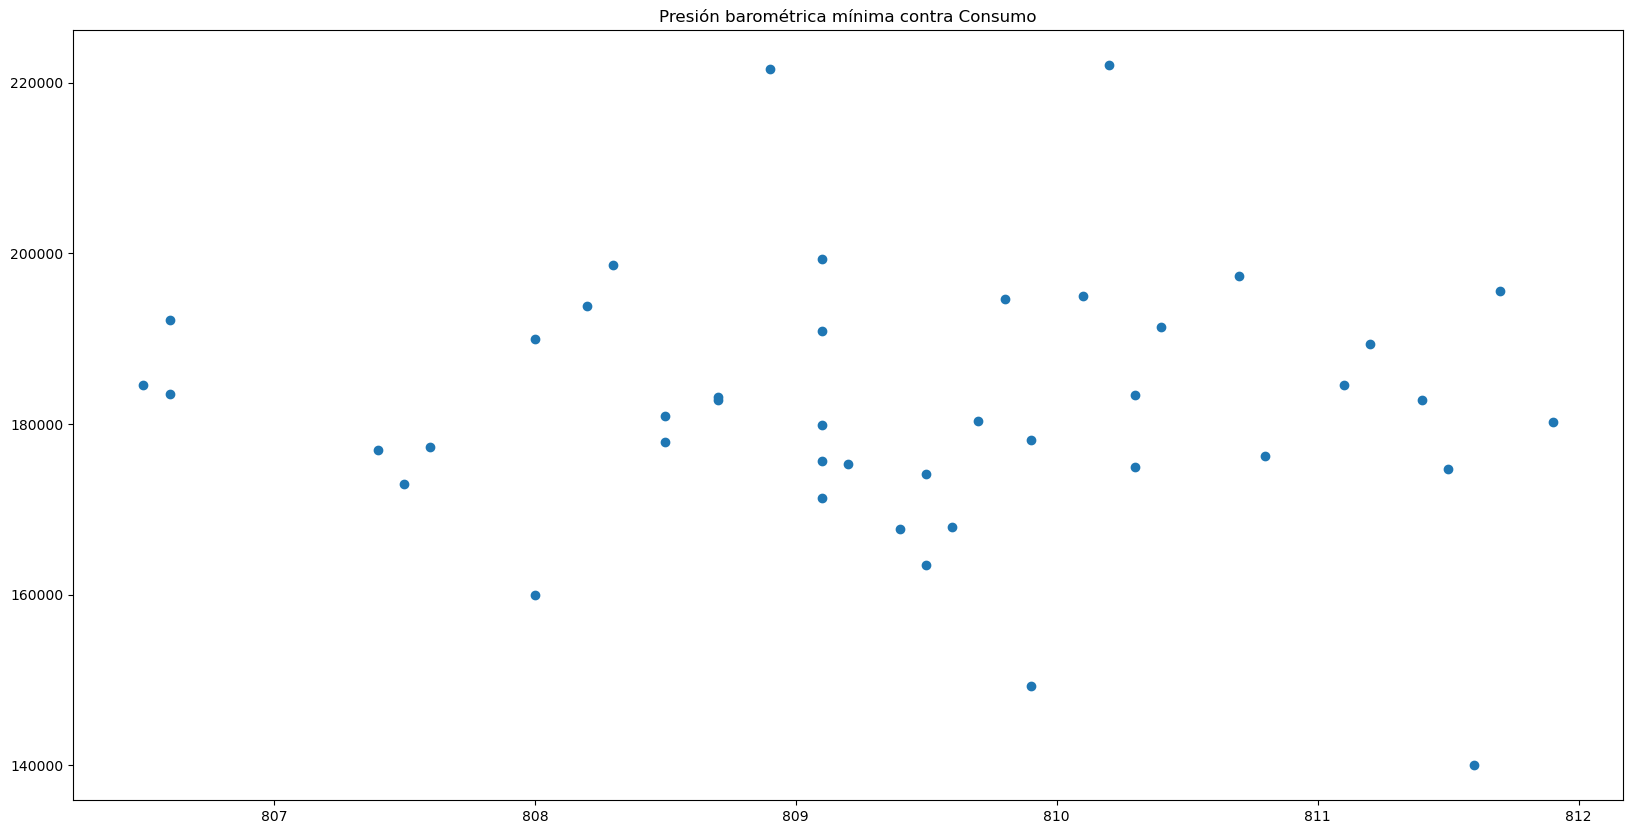

La correlación de Presión barométrica mínima y Consumo es: -0.06401703414163999


In [121]:
print("La correlación de Presión barométrica mínima y Consumo es:", relation_pbrmin_cons(data_frame['PBMin'], data_frame['MetrosConsumidos']))

## Relación existente entre presión barométrica media y consumo

In [122]:
def relation_pbrmed_cons(pbrmed, means):
  plt.scatter(pbrmed, means, alpha=1)
  plt.title("Presión barométrica media contra Consumo")
  plt.show()
  return np.corrcoef(pbrmed, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

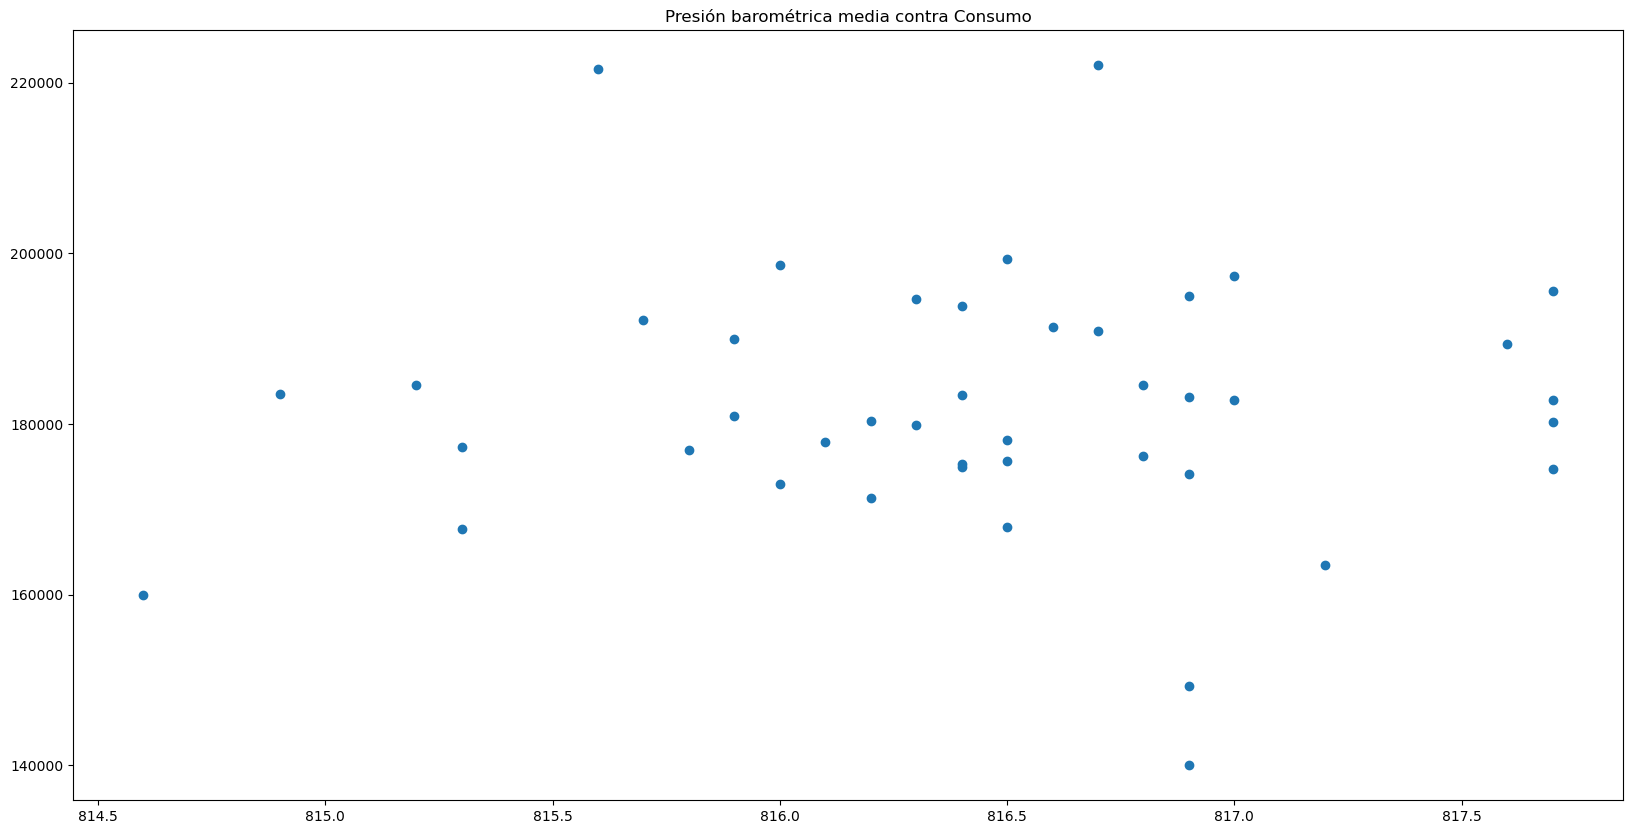

La correlación de Presión barométrica media y Consumo es: 0.01392073039354819


In [123]:
print("La correlación de Presión barométrica media y Consumo es:", relation_pbrmed_cons(data_frame['PBMed'], data_frame['MetrosConsumidos']))

## Relación existente entre velocidad del viento promedio y consumo

In [124]:
def relation_vvpro_cons(vvpro, means):
  plt.scatter(vvpro, means, alpha=1)
  plt.title("Velocidad del viento promedio contra Consumo")
  plt.show()
  return np.corrcoef(vvpro, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

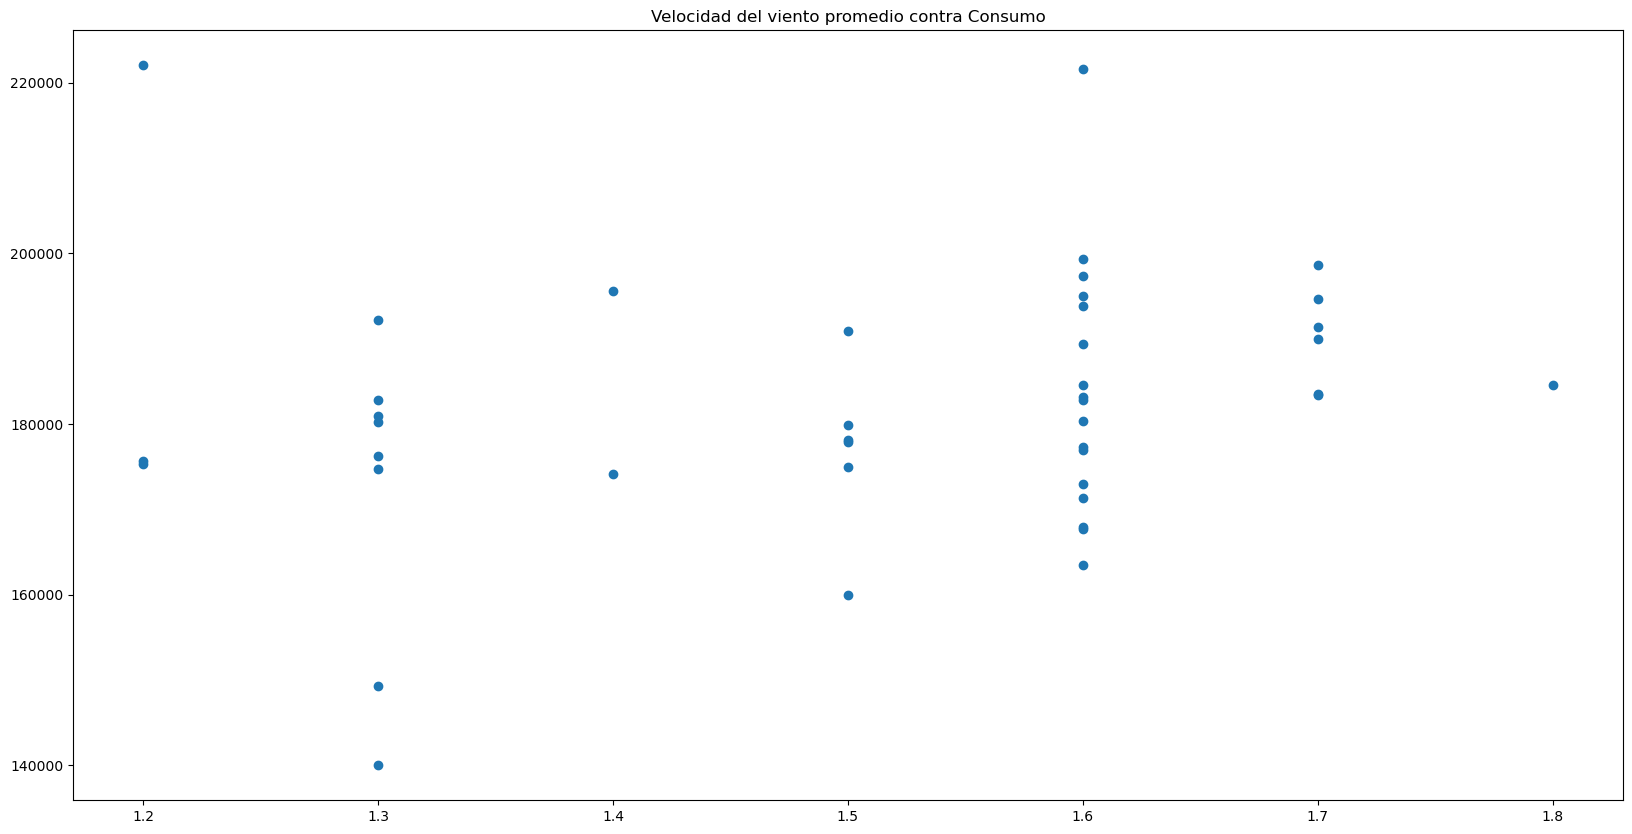

La correlación de Velocidad del viento promedio y Consumo es: 0.20131900742579334


In [125]:
print("La correlación de Velocidad del viento promedio y Consumo es:", relation_vvpro_cons(data_frame['VVPro'], data_frame['MetrosConsumidos']))

## Relación existente entre humedad relativa máxima y consumo

In [126]:
def relation_hrmax_cons(hrmax, means):
  plt.scatter(hrmax, means, alpha=1)
  plt.title("Humedad relativa máxima contra Consumo")
  plt.show()
  return np.corrcoef(hrmax, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

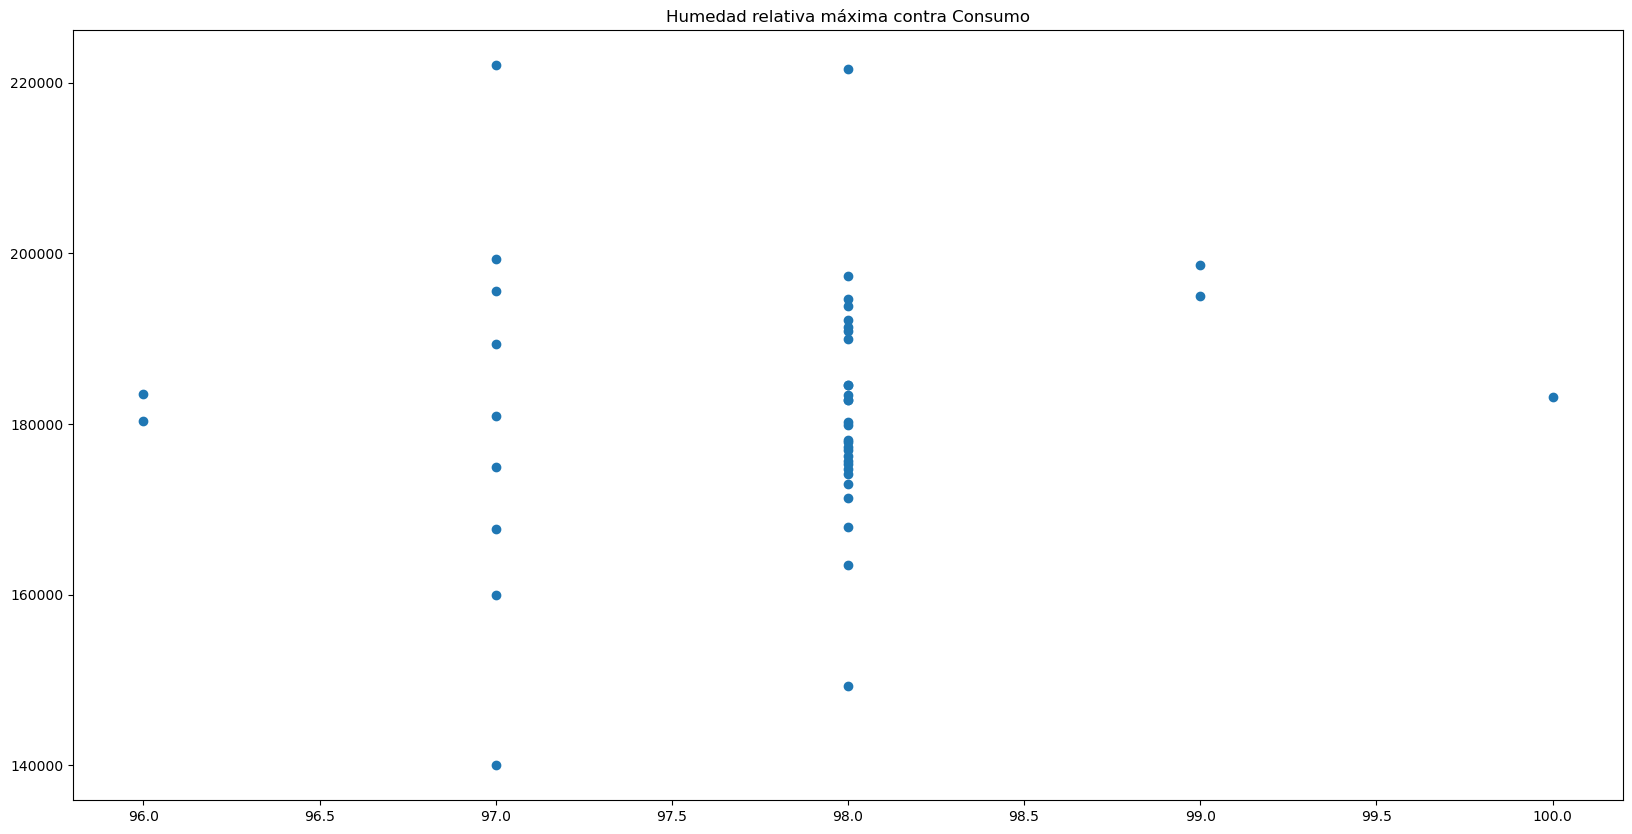

La correlación de Humedad relativa máxima y Consumo es: 0.09186120877080911


In [127]:
print("La correlación de Humedad relativa máxima y Consumo es:", relation_hrmax_cons(data_frame['HRMax'], data_frame['MetrosConsumidos']))

## Relación existente entre humedad relativa mínima y consumo

In [128]:
def relation_hrmin_cons(hrmin, means):
  plt.scatter(hrmin, means, alpha=1)
  plt.title("Humedad relativa mínima contra Consumo")
  plt.show()
  return np.corrcoef(hrmin, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

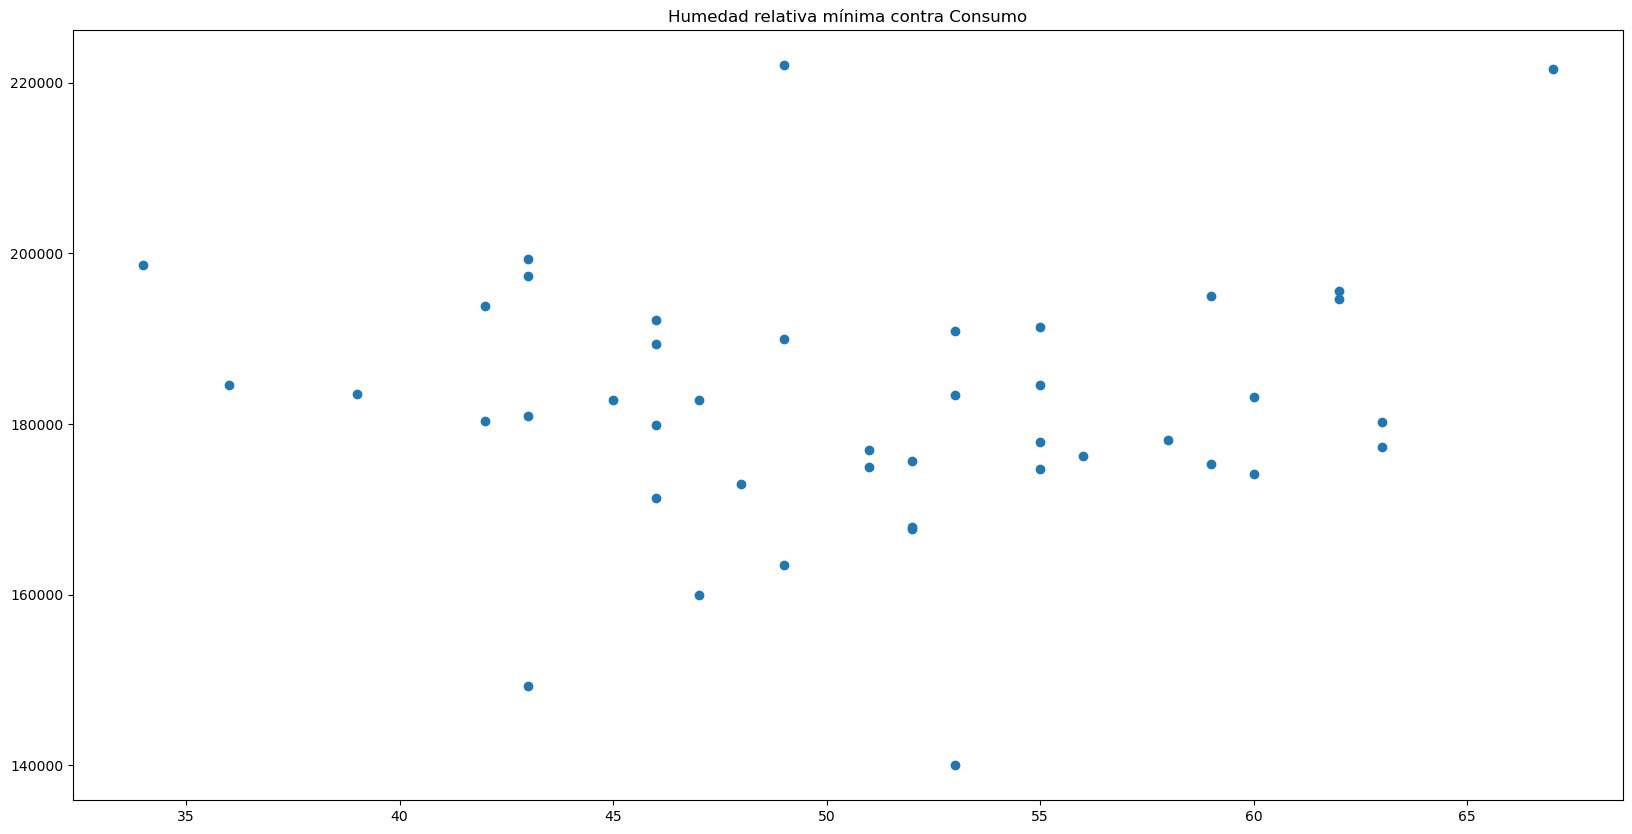

La correlación de Humedad relativa mínima y Consumo es: 0.05853676555343469


In [129]:
print("La correlación de Humedad relativa mínima y Consumo es:", relation_hrmin_cons(data_frame['HRMin'], data_frame['MetrosConsumidos']))

## Relación existente entre humedad relativa media y consumo

In [130]:
def relation_hrmed_cons(hrmed, means):
  plt.scatter(hrmed, means, alpha=1)
  plt.title("Humedad relativa media contra Consumo")
  plt.show()
  return np.corrcoef(hrmed, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

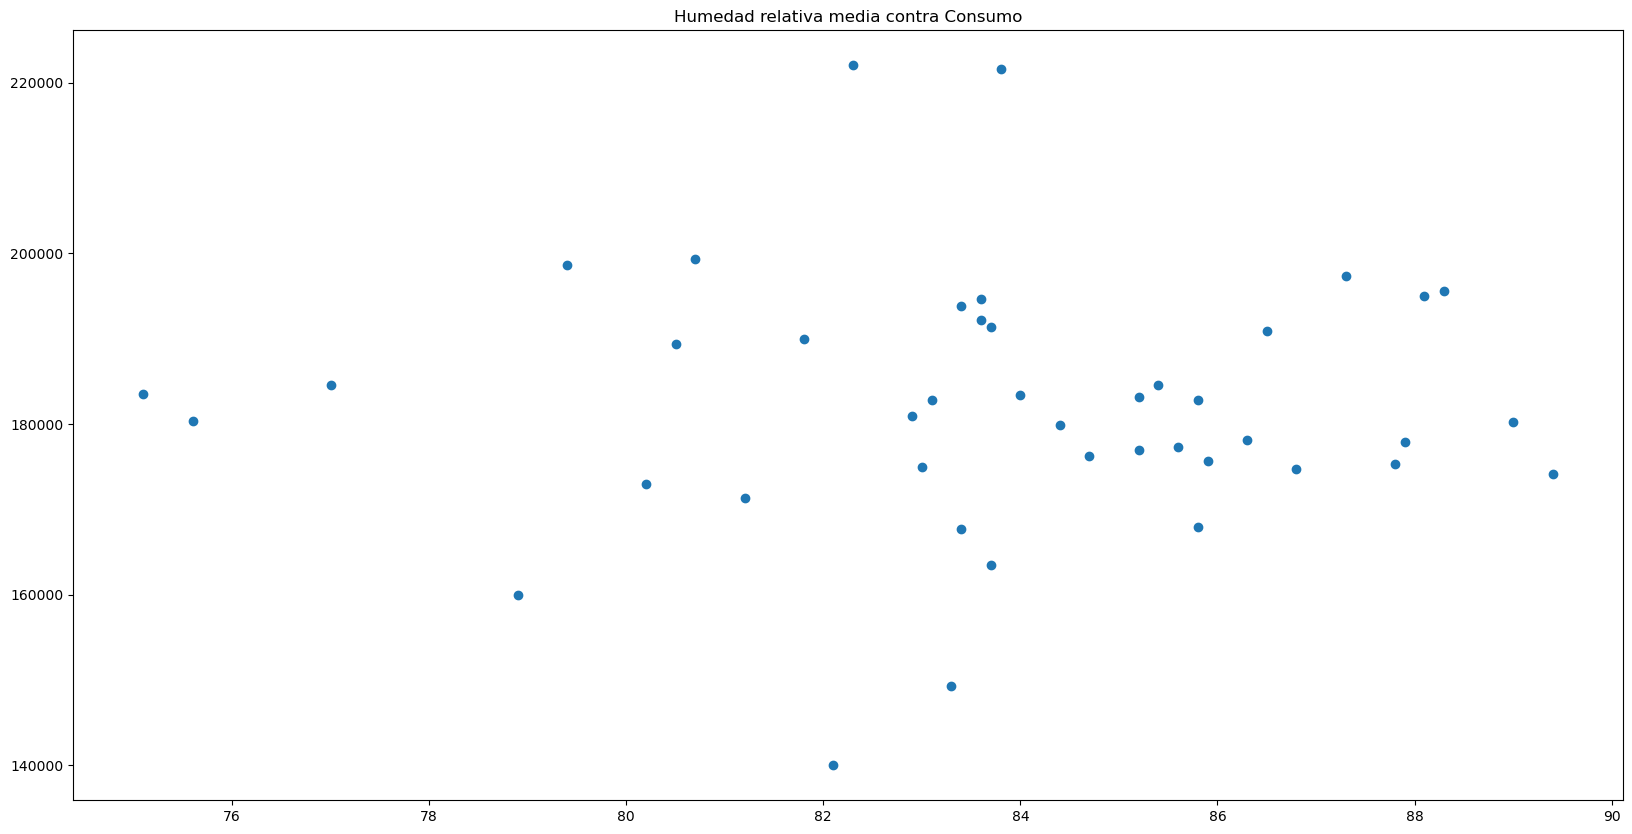

La correlación de Humedad relativa media y Consumo es: 0.012737506121103869


In [131]:
print("La correlación de Humedad relativa media y Consumo es:", relation_hrmed_cons(data_frame['HRMed'], data_frame['MetrosConsumidos']))

## Relación existente entre radiación solar media y consumo

In [132]:
def relation_rsmed_cons(rsmed, means):
  plt.scatter(rsmed, means, alpha=1)
  plt.title("Radiación solar mediaa contra Consumo")
  plt.show()
  return np.corrcoef(rsmed, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

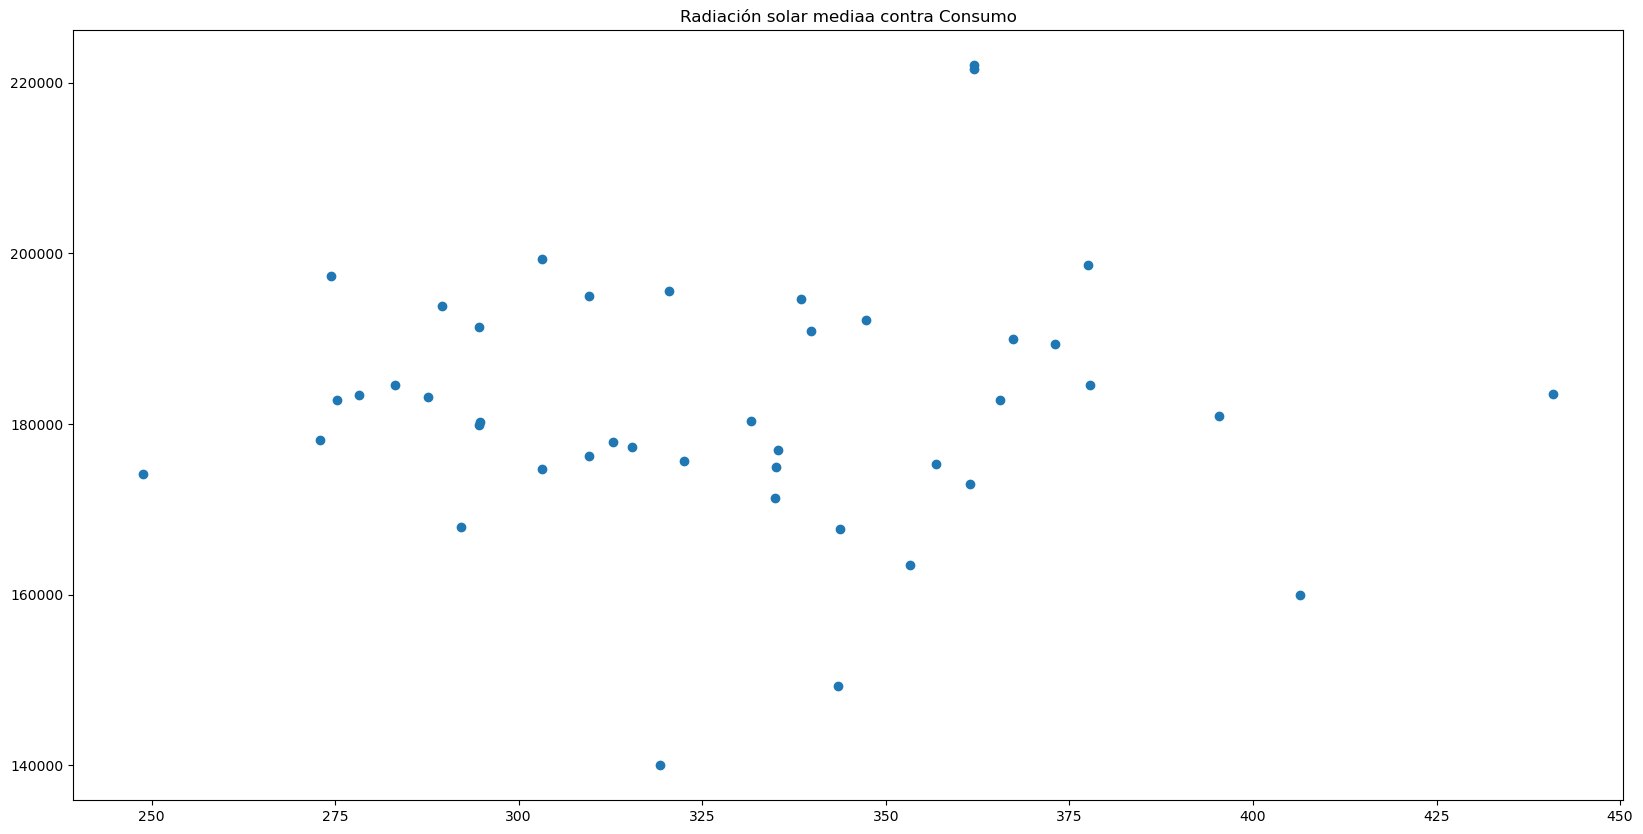

La correlación de radiación solar media y Consumo es: 0.03542435599743169


In [133]:
print("La correlación de radiación solar media y Consumo es:", relation_rsmed_cons(data_frame['RSMed'], data_frame['MetrosConsumidos']))

## Relación existente entre radiación solar máxima y consumo

In [134]:
def relation_rsmax_cons(rsmax, means):
  plt.scatter(rsmax, means, alpha=1)
  plt.title("Radiación solar máxima contra Consumo")
  plt.show()
  return np.corrcoef(rsmax, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

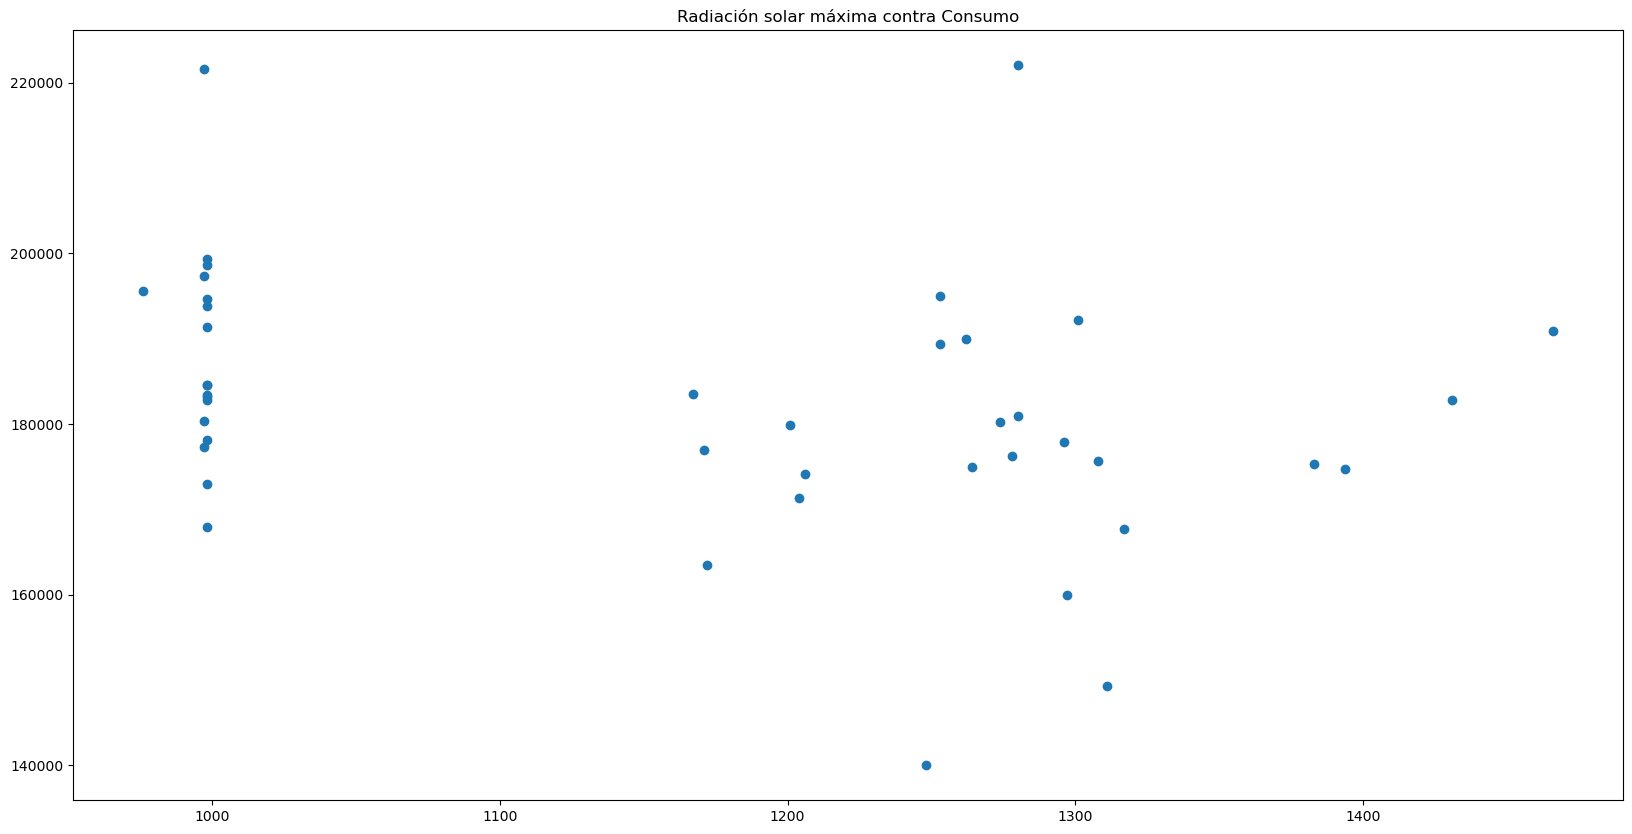

La correlación de radiación solar máxima y Consumo es: -0.28628293961473833


In [135]:
print("La correlación de radiación solar máxima y Consumo es:", relation_rsmax_cons(data_frame['RSMax'], data_frame['MetrosConsumidos']))

## Relación existente entre índice de aridez medio y consumo

In [136]:
def relation_iardz_cons(iardz, means):
  plt.scatter(iardz, means, alpha=1)
  plt.title("Índice de aridez medio contra Consumo")
  plt.show()
  return np.corrcoef(iardz, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se xtrae la correlación

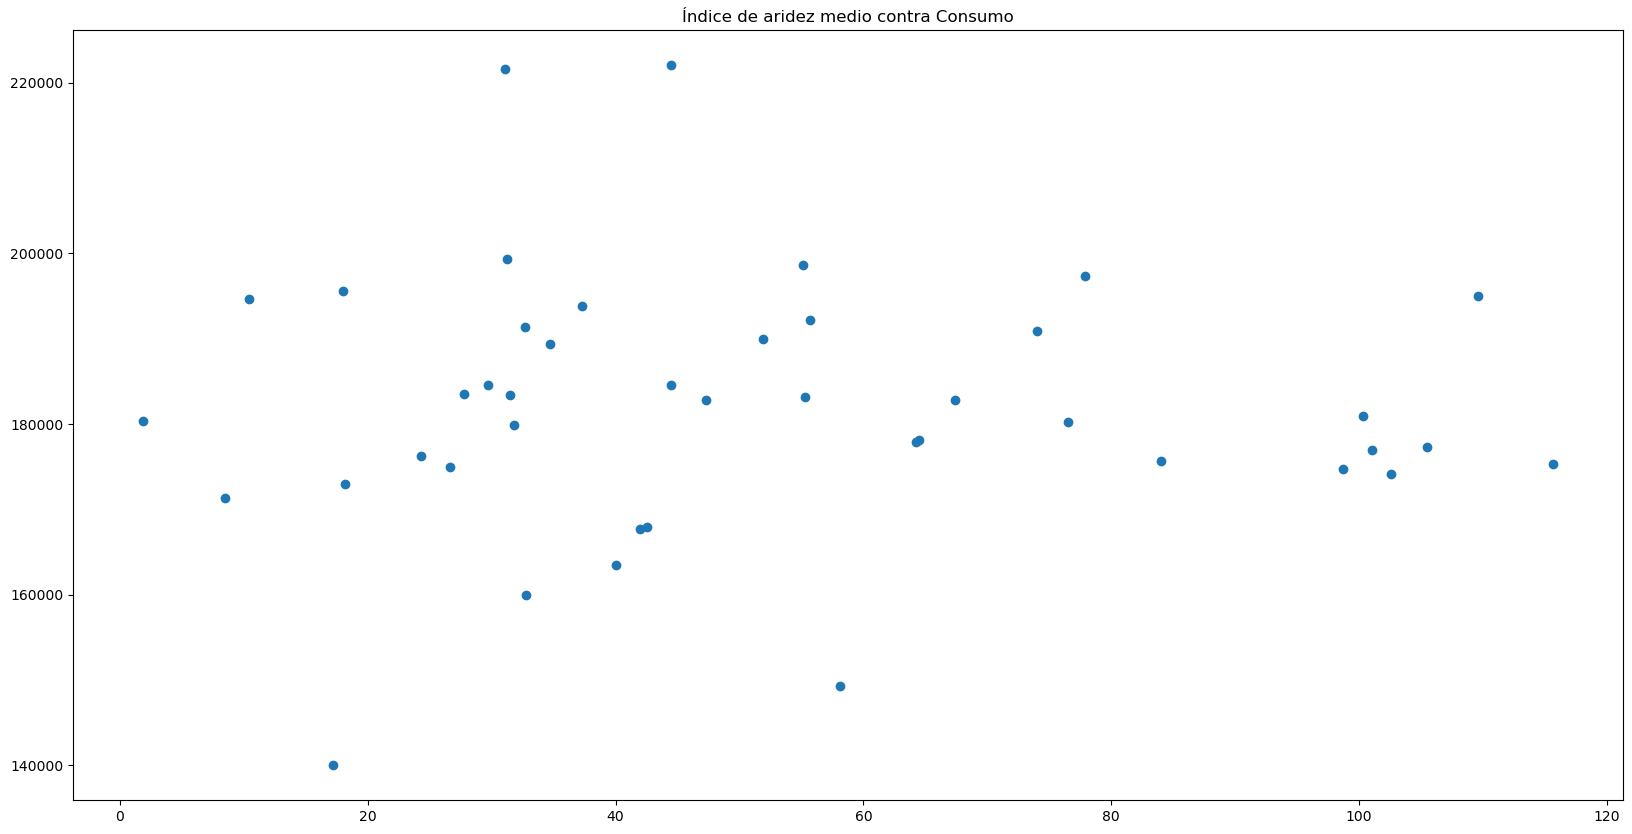

La correlación de índice de aridez medio y Consumo es: -0.014819314526080209


In [137]:
print("La correlación de índice de aridez medio y Consumo es:", relation_iardz_cons(data_frame['IAM'], data_frame['MetrosConsumidos']))

# Predicción del consumo de agua a un mes (LSTM)

## Extraer datos para la serie que se desea predecir

In [138]:
data_frame['Date'] = pd.to_datetime(data_frame.Date,format='%Y-%m-%d')
data_frame.index = data_frame['Date']
# df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(data_frame[['Date', 'MetrosConsumidos']])
#
#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

,MetrosConsumidos
Date,
2017-07-01,139987
2017-08-01,222055
2017-09-01,149277
2017-10-01,175709
2017-11-01,175364


## Visualización de la serie

In [139]:
len_data = len(data)
len_train = int(len_data*0.6) # 70%  = 2415
len_test = len_data - len_train # 30% = 604
print (len_data, '=', len_train, '+',len_test)

43 = 25 + 18


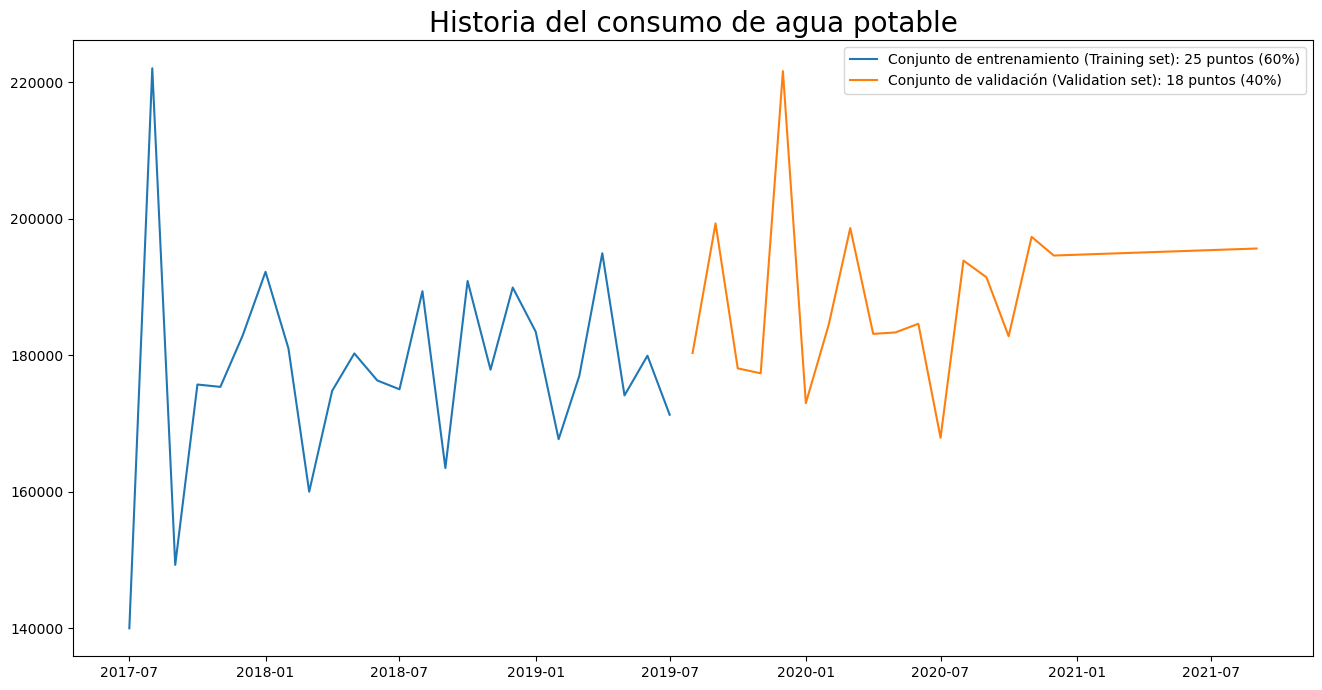

In [140]:
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (60%)'.format(len_train))
plt.plot(data['MetrosConsumidos'][len_train:], label='Conjunto de validación (Validation set): {} puntos (40%)'.format(len_test)) 
plt.title("Historia del consumo de agua potable", size = 20)
plt.legend()
plt.show()

## Preparación de los datos para el entrenamiento de la red LSTM

### Primero extrae los valores y se crea el objeto MinMaxScaler

In [141]:
# Creating train and test sets
dataset = data.values

# Create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = np.array(scaler.fit_transform(dataset))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1)
# dataset = pd.DataFrame(scaled_data,index=data.index, columns=['serie'])

In [142]:
dataset.shape

(43,)

### Función para crear los datos entrenamiento

In [143]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    ''' dataset: conjunto de datos
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la ventana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])

    return np.array(data), np.array(labels)

In [144]:
tf.random.set_seed(500)

In [145]:
#
# hiperparámetros para crear las secuencias
past_history = 12 # tamaño secuencias de entrada
future_target = 1 # días adelante
TRAIN_SPLIT = int(len_data*0.6) # nuḿero de datos entrenamiento

# secuencias de entrenamiento
X_train, y_train = univariate_data(dataset,0,TRAIN_SPLIT,past_history,future_target)
#
# Secuencias de validación
# No se usará ningún dato que el modelo haya visto
# X_test, y_test = univariate_data(dataset,TRAIN_SPLIT,None,past_history,future_target)
X_test, y_test = univariate_data(dataset,TRAIN_SPLIT,None,past_history,future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

25
(13, 12, 1)
(13,)
(5, 12, 1)
(5,)


In [146]:
print ('Ventana  de la historia pasada')
print (X_train[1])
print ('\n Valor del consumo a predecir')
print (y_train[1])

Ventana  de la historia pasada
[[1.        ]
 [0.11319881]
 [0.43527319]
 [0.43106936]
 [0.52242043]
 [0.63656967]
 [0.49962226]
 [0.24387094]
 [0.42396549]
 [0.49078813]
 [0.44248672]
 [0.42675586]]

 Valor del consumo a predecir
0.28610420626797306


### Crear el modelo LSTM

In [147]:
# shapes
input_shape = (X_train.shape[1], X_train.shape[2])
units = 50

# layers
inputs = Input(input_shape)
x = Dropout(0.2, name= 'Dropout_01')(inputs)
x = LSTM(units=units, name='LSTM_layer')(x)
#x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
#x = Dropout(0.4)
#x = LSTM(units=units//2, name='LSTM_layer_2')(x)
#x = Dropout(0.4)
x = Dropout(0.2, name= 'Dropout_02')(x)
outputs = Dense(1)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 Dropout_01 (Dropout)        (None, 12, 1)             0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### Compilar

In [148]:
model_01.compile(loss='mean_squared_error',optimizer=Adam(0.001))

### Entrenar el modelo

In [149]:
#history = model_01.fit(X_train,y_train,epochs=20,batch_size=32)
history = model_01.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.3059 - val_loss: 0.2060
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 0.2781 - val_loss: 0.1766
Epoch 3/10
1/1 [==============================] - 0s 33ms/step - loss: 0.2338 - val_loss: 0.1496
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 0.2087 - val_loss: 0.1248
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1882 - val_loss: 0.1022
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 0.1466 - val_loss: 0.0818
Epoch 7/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1317 - val_loss: 0.0636
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1201 - val_loss: 0.0475
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0910 - val_loss: 0.0336
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0643 - val_loss: 0.0221


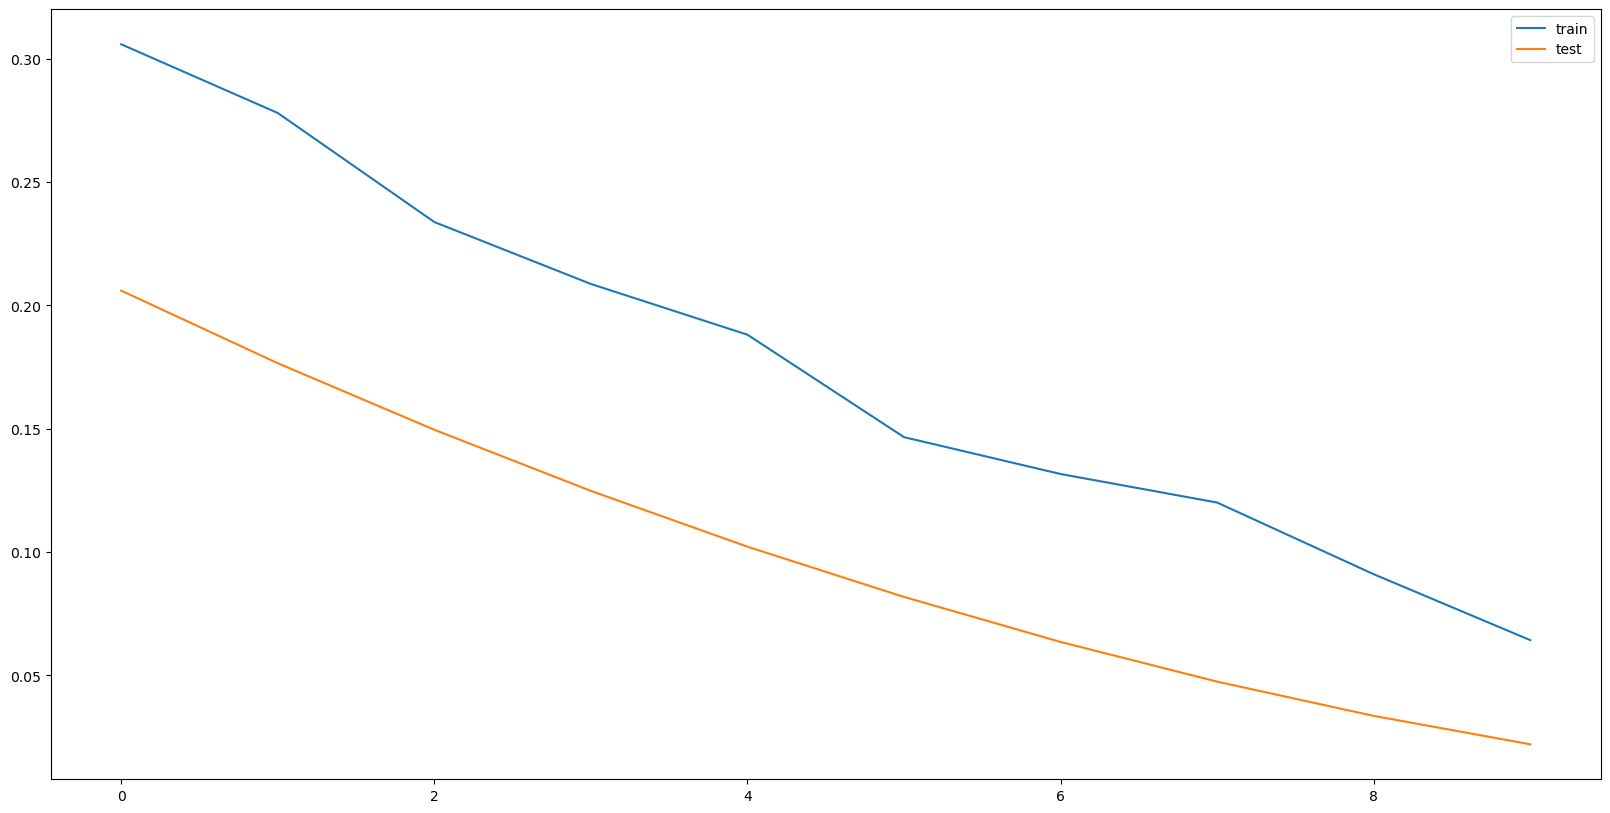

In [150]:
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.legend();

## Predicciones

### Preparar los datos de validación

In [151]:
X_test.shape

(5, 12, 1)

### Calcular predicciones

In [152]:
# predictions
prediction1 = model_01.predict(X_test)
#prediction = scaler.inverse_transform(prediction)]

1/1 [==============================] - 1s 631ms/step


In [153]:
print(prediction1.shape)
print(y_test.shape)

(5, 1)
(5,)


### Eliminar dimensiones sobrante para los gráficos

In [154]:
y_train_p1 = y_train #np.squeeze(y_train, axis=-1)
y_test_p1 = y_test#np.squeeze(y_test, axis=-1)
y_pred_p1 = np.squeeze(prediction1, axis=-1)

In [155]:
print(y_train_p1.shape)
print(y_test_p1.shape)
print(y_pred_p1.shape)

k=0
for i,j in zip(y_test_p1, y_pred_p1):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

(13,)
(5,)
(5,)
0.6267972900521519 0.32966092 0.29713636776325725
0.521457815470098 0.32878008 0.19267773062169402
0.6989813325534922 0.3259186 0.3730627176891428
0.6656187551786323 0.3271521 0.33846665199297865
0.6781571379831361 0.33165514 0.34650199329166886


### Gráfica de las predicciones

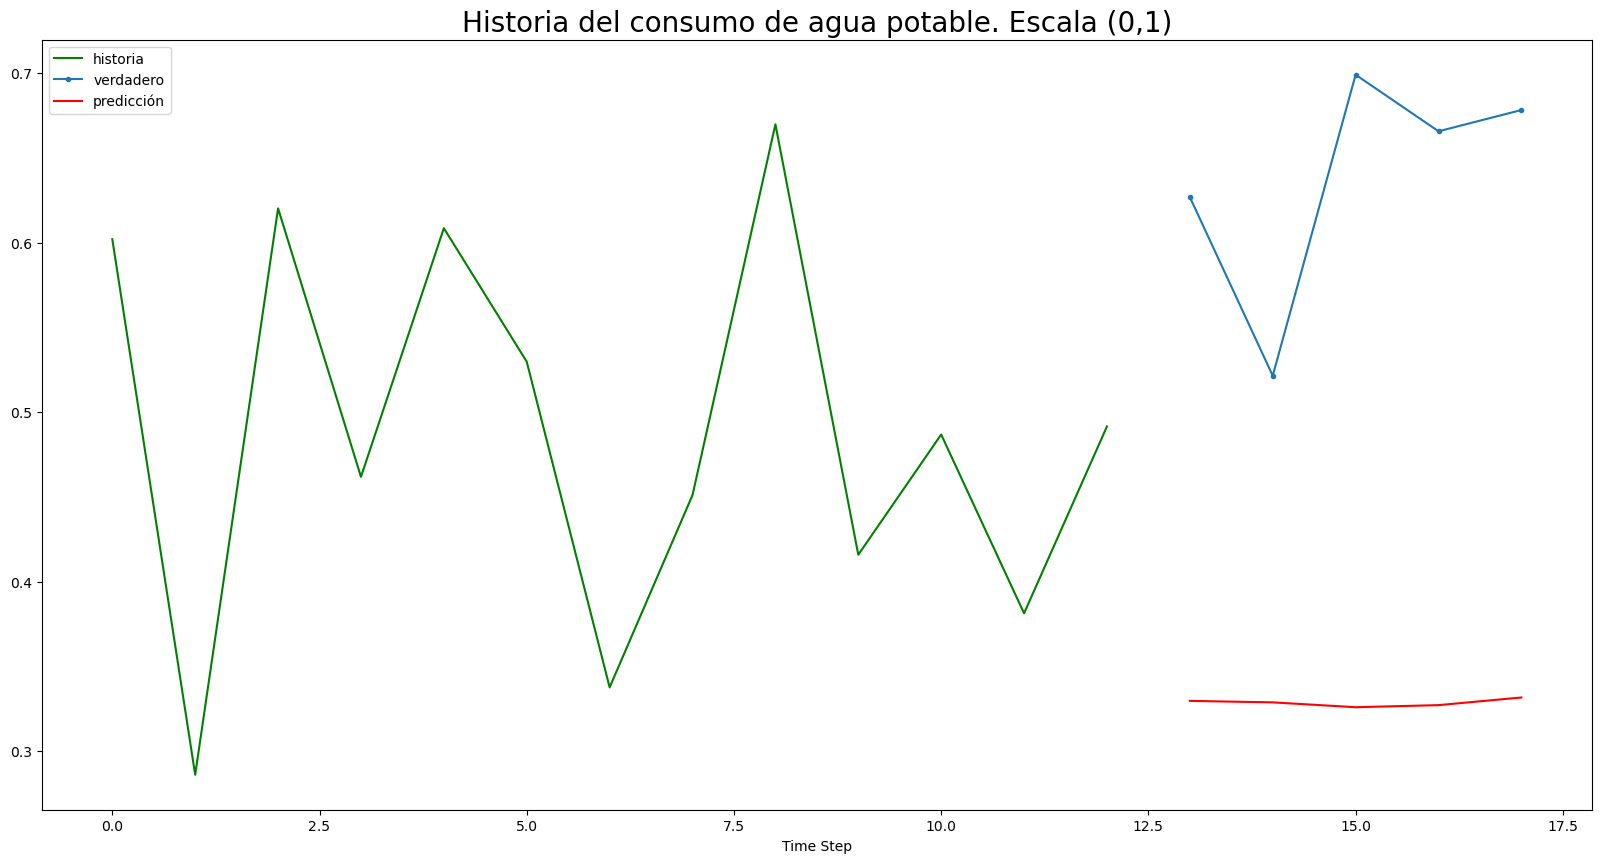

In [156]:
plt.plot(np.arange(0, len(y_train_p1)), y_train_p1, 'g', label="historia")
plt.plot(np.arange(len(y_train_p1), len(y_train_p1) + len(y_test_p1)), y_test_p1, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p1), len(y_train_p1) + len(y_test_p1)), y_pred_p1, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Historia del consumo de agua potable. Escala (0,1)", size = 20)
plt.legend()
plt.show();

### Regreso a la escala original

In [157]:
y_pred_or1 = scaler.inverse_transform(y_pred_p1.reshape(-1,1))
y_test_or1 = scaler.inverse_transform(y_test_p1.reshape(-1,1))

In [158]:
k=0
for i,j in zip(y_test_or1, y_pred_or1):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

[191427.] [167041.61] [24385.390625]
[182782.] [166969.33] [15812.671875]
[197351.] [166734.5] [30616.5]
[194613.] [166835.72] [27777.28125]
[195642.] [167205.27] [28436.734375]


In [159]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred_or1-y_test_or1,2)))
print(rmsLSTM )

25931.768761756928


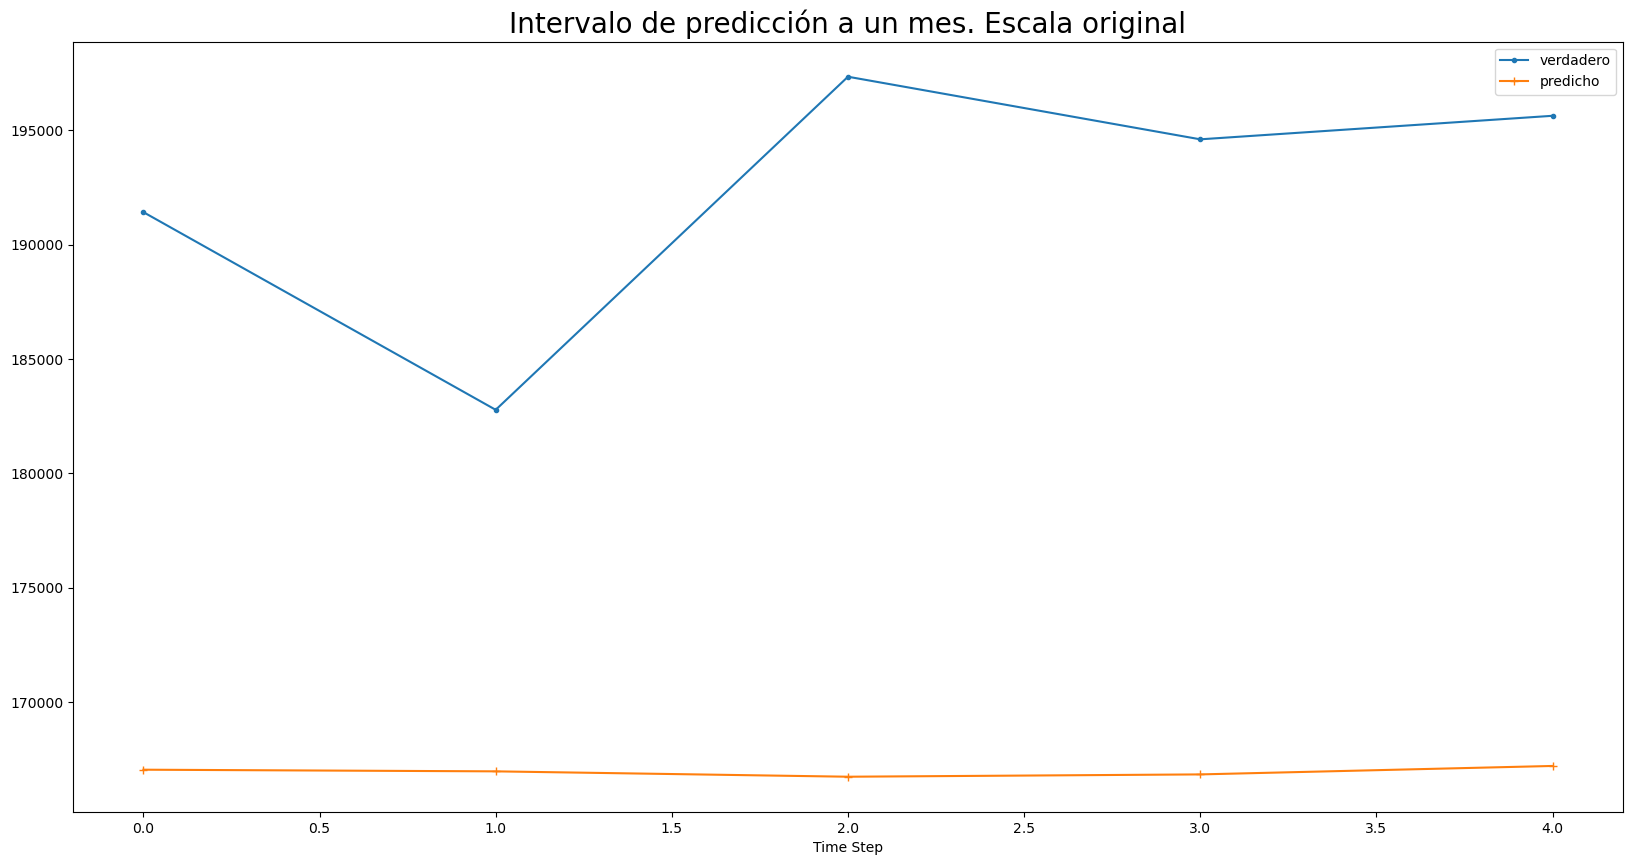

In [160]:
plt.plot(np.arange(0, len(y_test_or1)), y_test_or1, marker='.', label="verdadero")
plt.plot(np.arange(0, len(y_test_or1)), y_pred_or1, marker='+', label="predicho")
plt.xlabel('Time Step')
plt.annotate("rms = "+str(round(rmsLSTM,2)) , xy=(100, 140), size = 15)
plt.annotate("modelo = LSTM(50), timestep=12" , xy=(100, 146), size = 15)
plt.annotate("epochs=40" , xy=(100, 143), size = 15)
plt.title("Intervalo de predicción a un mes. Escala original", size = 20)
plt.legend()
plt.show();

### Guardar el modelo entrenado

In [161]:
model_01.save('../Datos/modelo_Consumo_1_dia.h5')

### Recuperar la configuración del modelo

In [162]:
model_01.get_config()

{'name': 'series_LSTM_model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 12, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_3'},
   'name': 'input_3',
   'inbound_nodes': []},
  {'class_name': 'Dropout',
   'config': {'name': 'Dropout_01',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.2,
    'noise_shape': None,
    'seed': None},
   'name': 'Dropout_01',
   'inbound_nodes': [[['input_3', 0, 0, {}]]]},
  {'class_name': 'LSTM',
   'config': {'name': 'LSTM_layer',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'shared_object_id': 2},
    'recurren

### Crear el modelo LSTM bidireccional

In [163]:
# shapes
input_shape = (X_train.shape[1], X_train.shape[2])
units_2 = 64
dropout = 0.2

# layers
inputs = Input(input_shape)
x = Dropout(dropout, name= 'Dropout_01')(inputs)
x = Bidirectional(LSTM(units, return_sequences=True,dropout=dropout,
    recurrent_dropout=dropout,))(x)
x = Bidirectional(LSTM(units//4, dropout=dropout,
    recurrent_dropout=dropout,))(x)
x = Dropout(dropout, name= 'Dropout_02')(x)
outputs = Dense(1)(x)

# model
model_02 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_02.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 Dropout_01 (Dropout)        (None, 12, 1)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 12, 100)          20800     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 24)               10848     
 nal)                                                            
                                                                 
 Dropout_02 (Dropout)        (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)           

### Compilar

In [164]:
model_02.compile(loss='mean_squared_error',optimizer=Adam(0.001),metrics=["mae"])

In [165]:
tf.random.set_seed(500)

history = model_02.fit(X_train, y_train,epochs=10,batch_size=64,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/10
1/1 [==============================] - 18s 18s/step - loss: 0.2502 - mae: 0.4880 - val_loss: 0.1276 - val_mae: 0.3529
Epoch 2/10
1/1 [==============================] - 0s 81ms/step - loss: 0.1965 - mae: 0.4200 - val_loss: 0.0881 - val_mae: 0.2916
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.1358 - mae: 0.3332 - val_loss: 0.0560 - val_mae: 0.2301
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.0925 - mae: 0.2697 - val_loss: 0.0313 - val_mae: 0.1682
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.0542 - mae: 0.2005 - val_loss: 0.0142 - val_mae: 0.1061
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.0561 - mae: 0.1848 - val_loss: 0.0049 - val_mae: 0.0545
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.0487 - mae: 0.1740 - val_loss: 0.0033 - val_mae: 0.0544
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.0195 - mae: 0.1111 - val

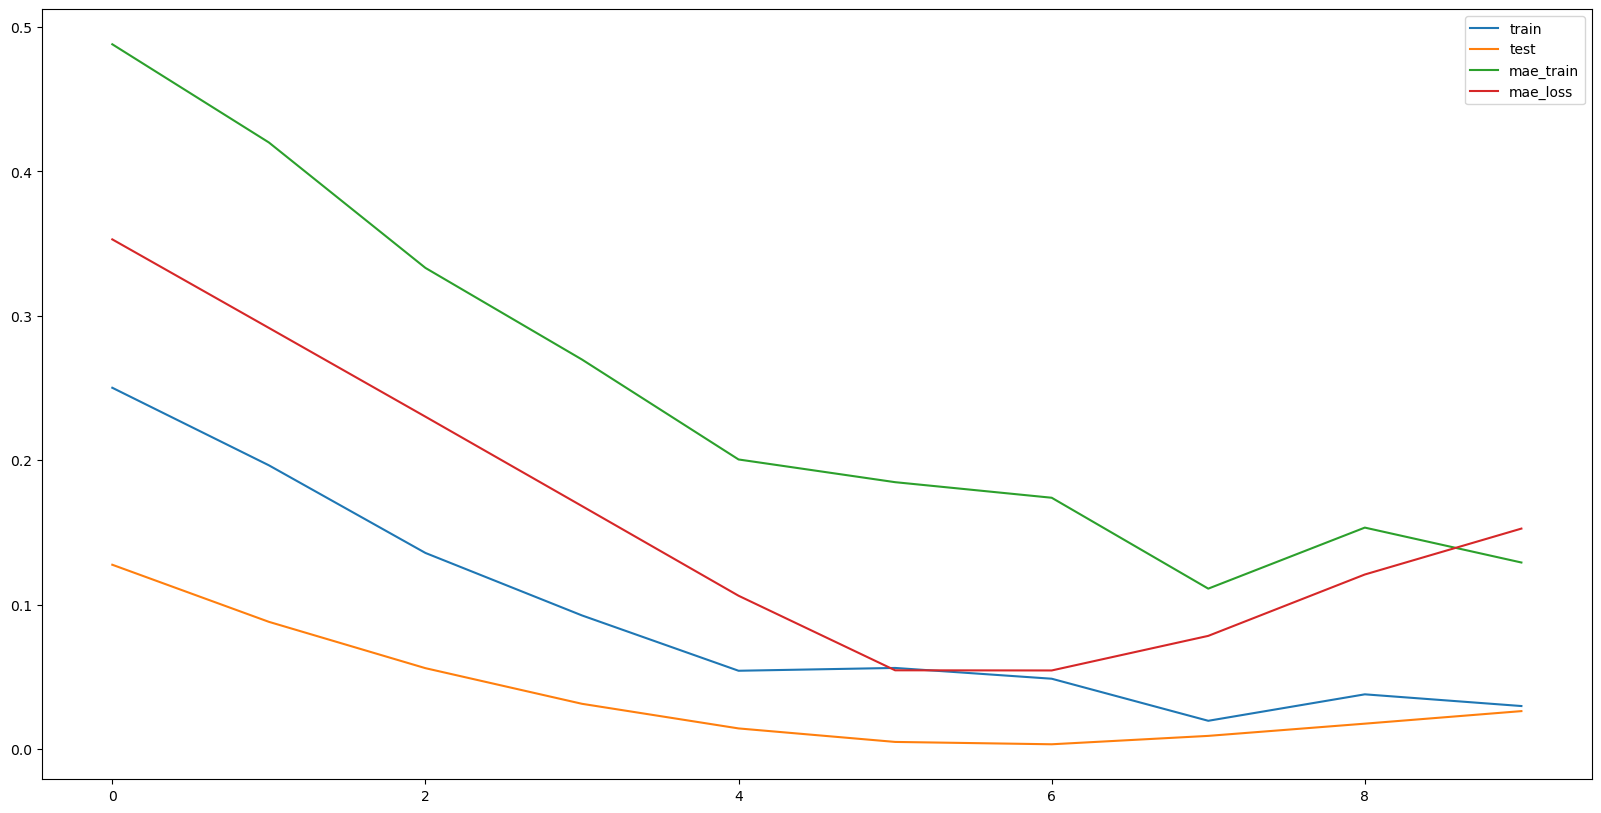

In [166]:
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.plot(history.history['mae'][:], label='mae_train')
plt.plot(history.history['val_mae'][:], label='mae_loss')
plt.legend();

### Predicciones

### Preparar los datos para validación

In [167]:
X_test.shape

(5, 12, 1)

### calcular predicciones

In [168]:
# predictions
prediction2 = model_02.predict(X_test)
#prediction = scaler.inverse_transform(prediction)

1/1 [==============================] - 1s 1s/step


In [169]:
print(prediction2.shape)
print(y_test.shape)

(5, 1)
(5,)


### Eliminar dimensiones sobrante para los gráficos

In [170]:
y_train_p2 = y_train #np.squeeze(y_train, axis=-1)
y_test_p2 = y_test#np.squeeze(y_test, axis=-1)
y_pred_p2 = np.squeeze(prediction2, axis=-1)

In [171]:
print(y_train_p2.shape)
print(y_test_p2.shape)
print(y_pred_p2.shape)

k=0
for i,j in zip(y_test_p2, y_pred_p2):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

(13,)
(5,)
(5,)
0.6267972900521519 0.64200693 -0.01520964363696553
0.521457815470098 0.64820266 -0.126744842229487
0.6989813325534922 0.6446169 0.054364430678949915
0.6656187551786323 0.64426774 0.02135101731318434
0.6781571379831361 0.65523535 0.022921787851147624


### Gráfica de las predicciones

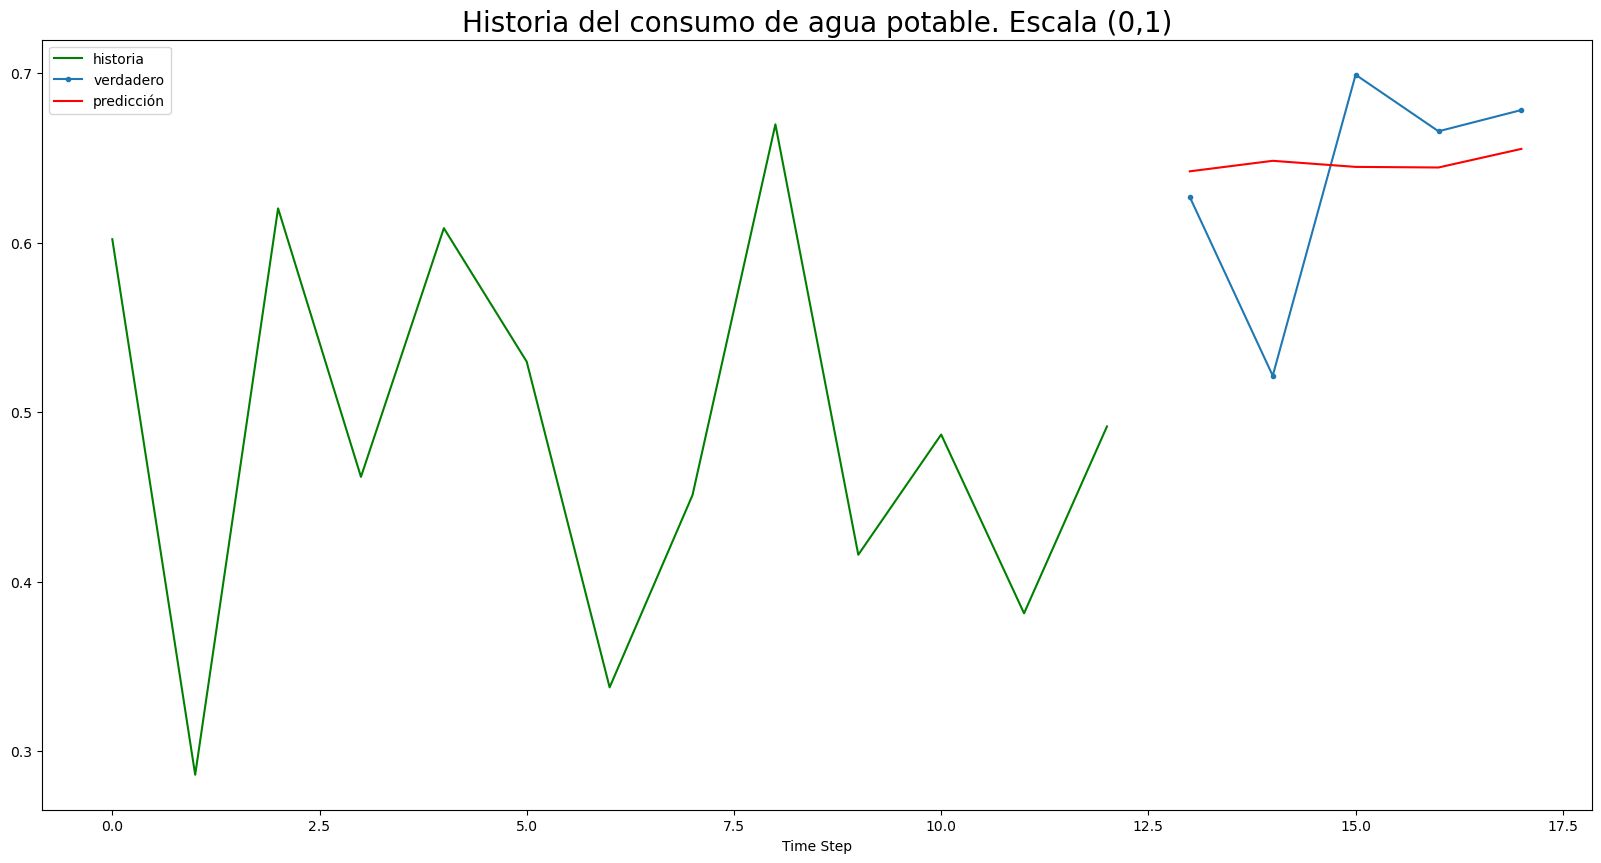

In [172]:
plt.plot(np.arange(0, len(y_train_p2)), y_train_p2, 'g', label="historia")
plt.plot(np.arange(len(y_train_p2), len(y_train_p2) + len(y_test_p2)), y_test_p2, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p2), len(y_train_p2) + len(y_test_p2)), y_pred_p2, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Historia del consumo de agua potable. Escala (0,1)", size = 20)
plt.legend()
plt.show();

### Regreso a la escala original

In [173]:
y_pred_or2 = scaler.inverse_transform(y_pred_p2.reshape(-1,1))
y_test_or2 = scaler.inverse_transform(y_test_p2.reshape(-1,1))

In [174]:
k=0
for i,j in zip(y_test_or2, y_pred_or2):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

[191427.] [192675.22] [-1248.21875]
[182782.] [193183.7] [-10401.703125]
[197351.] [192889.42] [4461.578125]
[194613.] [192860.77] [1752.234375]
[195642.] [193760.84] [1881.15625]


In [175]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred_or2-y_test_or2,2)))
print(rmsLSTM )

5220.50249412469


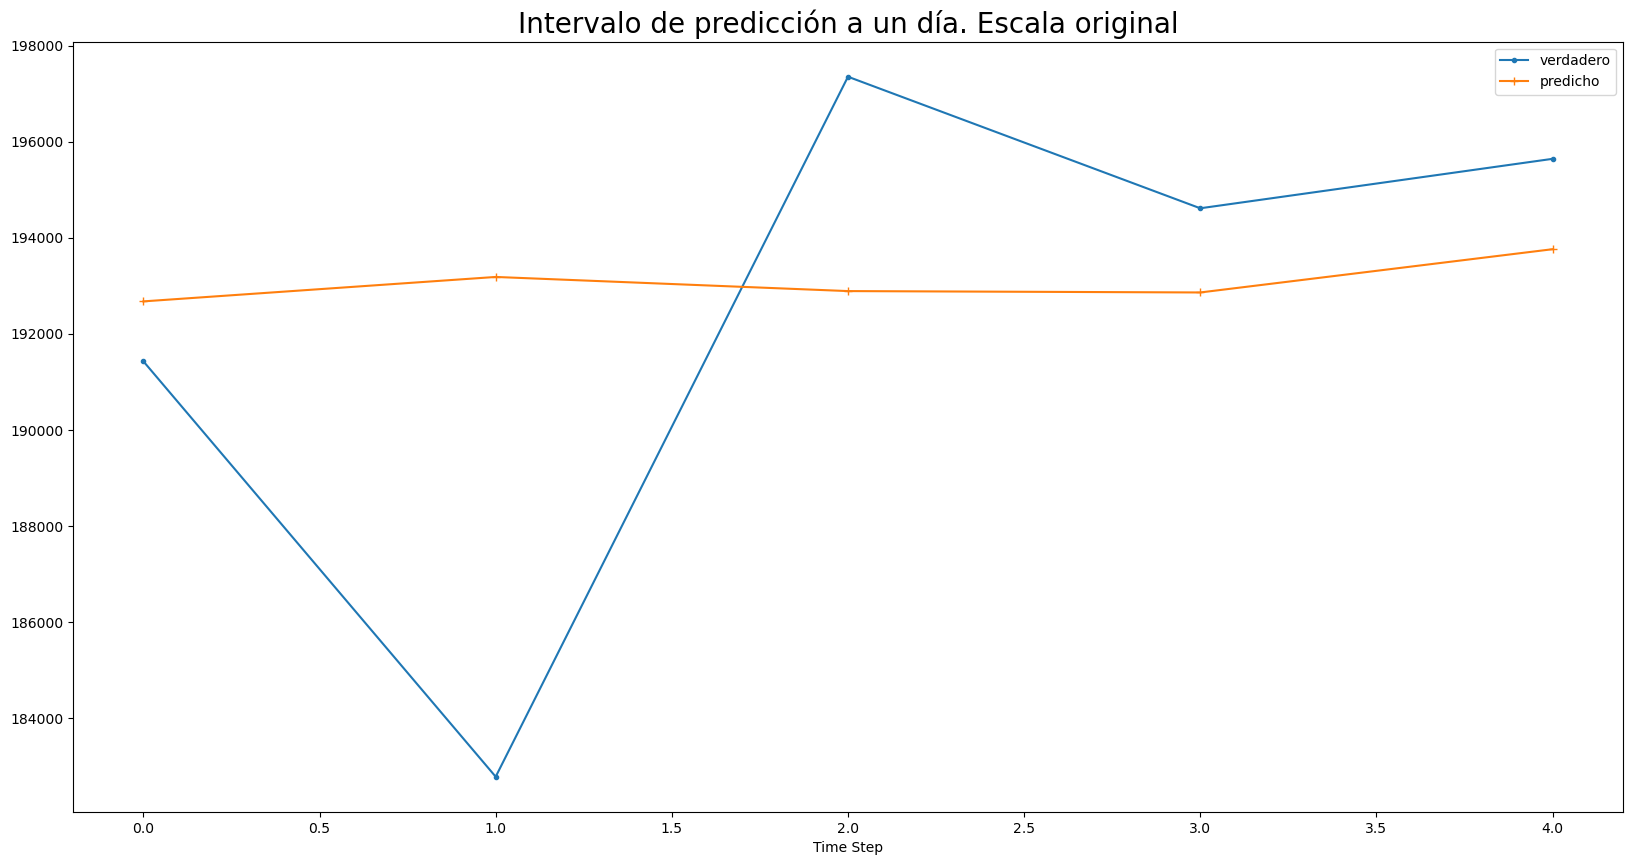

In [176]:
plt.plot(np.arange(0, len(y_test_or2)), y_test_or2, marker='.', label="verdadero")
plt.plot(np.arange(0, len(y_test_or2)), y_pred_or2, marker='+', label="predicho")
plt.xlabel('Time Step')
plt.annotate("rms = "+str(round(rmsLSTM,2)) , xy=(100, 140), size = 15)
plt.annotate("modelo = LSTM(50), timestep=12" , xy=(100, 146), size = 15)
plt.annotate("epochs=40" , xy=(100, 143), size = 15)
plt.title("Intervalo de predicción a un día. Escala original", size = 20)
plt.legend()
plt.show();